### Computational Environment
This notebook was executed on the following hardware:
* **Machine:** MacBook Air (M2, 2022)
* **Chip:** Apple M2 (8-core CPU, 8/10-core GPU)
* **Accelerator:** Metal Performance Shaders (MPS) via TensorFlow-Metal
* **Optimization:** Uses `tf.keras.optimizers.legacy.Adam` to enable GPU acceleration on macOS.
---

From Step 8 onwards, it was executed on the following hardware:  


**Experimental Protocol: Best-Model Evaluation**

To ensure scientific rigour and clinical relevance in this Phase 5 study, the following protocols are observed:

* **Metric Priority:** The primary monitor for model selection is Validation AUC (val_auc), as it provides a threshold-independent measure of the model's ability to distinguish between Benign and Malignant classes.

* **Weights Selection:** All reported metrics and confusion matrices are derived from the 'Best Weights' captured via ModelCheckpoint. These weights represent the epoch of maximum generalisation before the onset of overfitting.

* **Metrics Discrepancy Note:** Readers may observe slight differences between the training history logs and the final Evaluation Report. The evaluation report represents the true Peak State of the model, whereas the history logs represent the sequential learning path.

## Import Libraries

In [1]:
# Standard Library
import os
import sys
import time
import random
import gc
import itertools
from pathlib import Path

# Numerical & Data Handling
import numpy as np
import pandas as pd

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image

# Progress Bar
from tqdm import tqdm

# Sklearn Utilities & Metrics
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

In [9]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## Reproducibility Setup

In [2]:
# Set Python environment variables
os.environ['PYTHONHASHSEED'] = '0'
# TF to use deterministic ops where possible
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set Random Seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"Global Random Seed set to: {seed}")

Global Random Seed set to: 42


It is noted that on Apple M2, minor floating-point jitter is unavoidable.

## TQDM bar for Training and Tuning

In [3]:
class TqdmCallback(keras.callbacks.Callback):
    def __init__(self, pbar):
        super().__init__()
        self.pbar = pbar

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.pbar.update(1)
        
        # Calculate gap
        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        gap = train_acc - val_acc
        
        self.pbar.set_postfix({
            "loss": f"{logs.get('loss', 0):.3f}",
            "v_auc": f"{logs.get('val_auc', 0):.3f}",
            "gap": f"{gap:.3f}"
        })
        # Prevent the "multi-line" ghosting
        self.pbar.refresh()

# 1. Defining the problem and assembling a dataset
**Objective:**
To build a binary classification model capable of detecting breast cancer (Malignant vs. Benign) from mammography patches.

**Problem Type:**
Binary Classification (Imbalanced).

**Dataset:**
The [CBIS-DDSM](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) (Curated Breast Imaging Subset of DDSM) dataset.
- **Input:** 224x224 grayscale images of mammogram masses.
- **Output:** A probability score (0-1) indicating malignancy.
- **Preprocessing:** Images were preprocessed externally to square crops preserving aspect ratio, ensuring no tumor distortion.

In [4]:
# Load the config file created by preprocess.py script
config_path = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json")
print(f"Project Configuration found at: {config_path}")

Project Configuration found at: /Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json


# 2. Choosing a measure of success

To ensure clinical relevance, we evaluate the model using a multi-dimensional approach rather than a single metric.

**1. Primary Metric: AUC-ROC**
   - Serves as the global performance benchmark, robust to class imbalance.

**2. Clinical Safety Metrics:**
   - **Sensitivity (Recall):** Critical for minimizing False Negatives (missing cancer).
   - **Specificity:** Critical for minimizing False Positives (reducing unnecessary biopsies).

**3. Precision & F1-Score:**
   - Monitors the "False Alarm" rate and provides a balanced view of performance on the minority (Malignant) class.

**4. Confusion Matrix:**
   - We will inspect raw TP, TN, FP, FN counts to understand specific failure modes.

# 3. Deciding on an evaluation protocol
To ensure the model generalizes well to new patients, we utilize a **Hold-Out Validation Set**.

**Protocol Details:**
- **Split Ratio:** 80% Training / 20% Validation.
- **Grouping:** The split was performed using `GroupShuffleSplit` on `patient_id`.
    - *Constraint:* All images from the same patient (e.g., CC and MLO views) are kept in the same set to prevent **Data Leakage**.
- **Test Set:** A separate, official test set provided by CBIS-DDSM is held back completely until the final evaluation.

# 4. Preparing the Data
## 4.1 Configuration & Imports

In [5]:
# Configuration (v3_square folder)
BASE_DIR = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square")
GREY_DIR = BASE_DIR / "processed_greyscale"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42

print(f"Configuration set at \nBase Dir: {BASE_DIR}")

Configuration set at 
Base Dir: /Users/ay/Downloads/Github/FYP/processed_data_v3_square


## 4.2 Visual Audit (Verification)

Visual check of preprocessed data


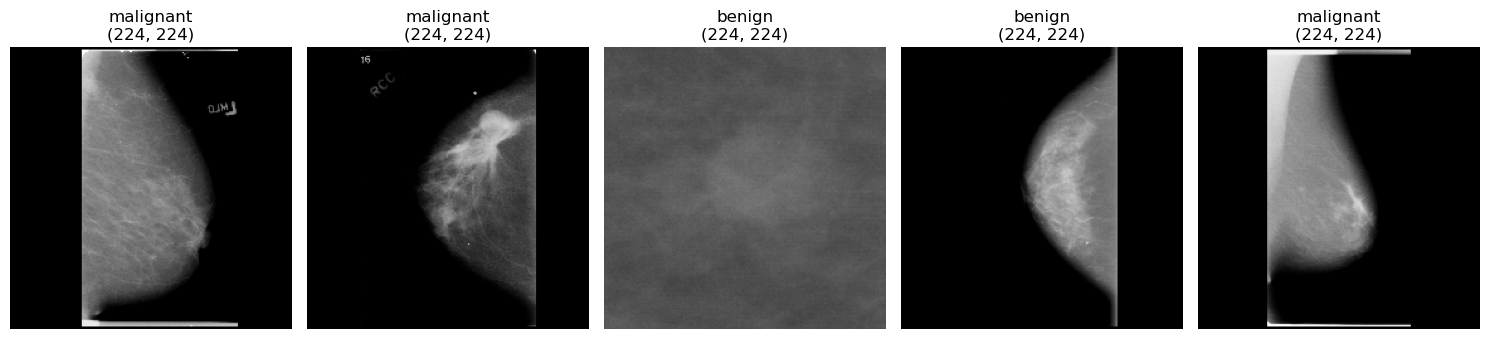

In [5]:
# Checks if images are square, padded correctly, and readable
def verify_data_integrity(n=3):
    train_dir = GREY_DIR / "train"
    # Get list of all png files
    all_files = list(train_dir.rglob("*.png"))
    
    if not all_files:
        print("No images found.")
        return

    # Pick random samples to verify
    samples = random.sample(all_files, n)
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(samples):
        try:
            img = Image.open(img_path)
            img_arr = np.array(img)
            
            plt.subplot(1, n, i+1)
            plt.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
            # Title shows class (benign/malignant) and dimensions
            plt.title(f"{img_path.parent.name}\n{img_arr.shape}")
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            
    plt.tight_layout()
    plt.show()

print("Visual check of preprocessed data")
verify_data_integrity(n=5)

## 4.3 Data Generators (Loading)

In [6]:
# Create ImageDataGenerator (Rescaling augmentation only)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Set:")
train_gen = train_datagen.flow_from_directory(
    GREY_DIR / "train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED
)

print("\nLoading Validation Set:")
val_gen = test_datagen.flow_from_directory(
    GREY_DIR / "val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED,
    # Do not shuffle Val set
    shuffle=False
)

# Quick check of the class indices
print(f"\nClass Indices: {train_gen.class_indices}")

# Get raw counts
train_counts = np.bincount(train_gen.classes)
val_counts = np.bincount(val_gen.classes)

print(f"Train class counts: {train_counts}")
print(f"Val class counts:   {val_counts}")

Loading Training Set:
Found 1061 images belonging to 2 classes.

Loading Validation Set:
Found 257 images belonging to 2 classes.

Class Indices: {'benign': 0, 'malignant': 1}
Train class counts: [568 493]
Val class counts:   [113 144]


## 4.4 Verify no Data Leakage

In [23]:
# Get all filenames from the folders directly
def get_filenames(subset_dir):
    files = []
    for root, dirs, filenames in os.walk(subset_dir):
        for f in filenames:
            # Only count images, ignore hidden files like .DS_Store
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                files.append(f)
    return set(files)

# Gather filenames
train_files = get_filenames(GREY_DIR / "train")
val_files = get_filenames(GREY_DIR / "val")
test_files = get_filenames(GREY_DIR / "test")

# Check for overlaps
train_test_overlap = train_files.intersection(test_files)
val_test_overlap = val_files.intersection(test_files)

if not train_test_overlap and not val_test_overlap:
    print("Test set is separate from Train/Val.")
else:
    if train_test_overlap: print(f"Leakage: {len(train_test_overlap)} files in Train & Test")
    if val_test_overlap: print(f"Leakage: {len(val_test_overlap)} files in Val & Test")

Test set is separate from Train/Val.


## 4.5 Define Class Weights

In [7]:
# Calculate class weights dynamically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(weights))

print(f"Calculated Class Weights: {class_weights_dict}")

Calculated Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


## 4.6 Helper Functions for Evaluation and Visualisation

In [8]:
# Plot accuracy and loss curves for training and validation
def plot_training_history(history, title_prefix="Model"):
    # Check if passing a Keras history object or a dictionary/dataframe
    hist = history.history if hasattr(history, 'history') else history
    
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Generate a Baseline Table, classification report and a confusion matrix heatmap
def eval_model_perf(model, generator, step_name="Step X", baseline_acc=0.5353):
    # Reset generator to ensure order matches labels
    generator.reset()
    
    # Get metrics from model.evaluate
    results = model.evaluate(generator, verbose=0)
    metrics_dict = dict(zip(model.metrics_names, results))
    
    # Generate predictions for Specificity and Confusion Matrix (reset generator)
    generator.reset()
    y_pred_raw = model.predict(generator, verbose=0)
    y_pred = (y_pred_raw > 0.5).astype(int).flatten()
    y_true = generator.classes
    
    # Calculate Confusion Matrix & Clinical Metrics
    cm = confusion_matrix(y_true, y_pred)
    # Handle cases where the model might predict only one class
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        # Fallback for single-class predictions
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
    
    # Manual calculations to ensure transparency
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / len(y_true)
    
    # Print Statistical Power Table
    print(f"\n{step_name} Evaluation: Statistical Power Check")
    print("-" * 60)
    print(f"{'Metric':<20} | {'Baseline':<10} | {'Model (Val)':<10}")
    print("-" * 60)
    print(f"{'Accuracy':<20} | {baseline_acc:<10.4f} | {accuracy:.4f}")
    
    # Find AUC in the metrics_dict (handle case-sensitive names)
    auc_val = metrics_dict.get('auc', metrics_dict.get('AUC', 0.5000))
    print(f"{'AUC-ROC':<20} | {'0.5000':<10} | {auc_val:.4f}")
    print(f"{'Sensitivity':<20} | {'0.0000':<10} | {sensitivity:.4f}")
    print(f"{'Specificity':<20} | {'1.0000':<10} | {specificity:.4f}")
    print("-" * 60)
    
    # Classification Report
    print("\nDetailed Classification Report:")
    # Map indices back to names for the report
    target_names = list(generator.class_indices.keys())
    target_names = [name.capitalize() for name in target_names]
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Heatmap Visualisation
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Pred {target_names[0]}', f'Pred {target_names[1]}'],
                yticklabels=[f'True {target_names[0]}', f'True {target_names[1]}'])
    plt.title(f'Confusion Matrix ({step_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Return dictionary
    return {
        "Val Acc": accuracy,
        "Val AUC": auc_val,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    }

# Step 5: Developing a model that does better than a baseline
## 5.1. Majority Baseline

In [13]:
# Distribution Stats
n_benign = (train_gen.classes == 0).sum()
n_malignant = (train_gen.classes == 1).sum()
total = len(train_gen.classes)

# Determine majority class and its baseline accuracy
if n_benign >= n_malignant:
    majority_class = "Benign (0)"
    majority_baseline_acc = n_benign / total
    # Cannot catch any malignant cases
    baseline_sensitivity = 0.0
    # Correctly identifies all benign cases
    baseline_specificity = 1.0
else:
    majority_class = "Malignant (1)"
    majority_baseline_acc = n_malignant / total
    baseline_sensitivity = 1.0
    baseline_specificity = 0.0

print("Majority Baseline: Clinical Metric Floor")
print("-" * 40)
print(f"Majority Class:      {majority_class}")
print(f"Baseline Accuracy:    {majority_baseline_acc:.4f}")
print(f"Baseline AUC:         0.5000")
print("-" * 40)
print("Baseline Performance (Predicting Majority Only):")
print(f"  Sensitivity:        {baseline_sensitivity:.4f}")
print(f"  Specificity:        {baseline_specificity:.4f}")

Majority Baseline: Clinical Metric Floor
----------------------------------------
Majority Class:      Benign (0)
Baseline Accuracy:    0.5353
Baseline AUC:         0.5000
----------------------------------------
Baseline Performance (Predicting Majority Only):
  Sensitivity:        0.0000
  Specificity:        1.0000


### 5.1.1 Save the Results

In [20]:
# Create a dictionary for the baseline stats
baseline_summary = {
    "Majority Baseline": {
        "Val Acc": majority_baseline_acc,
        "Val AUC": 0.5000,
        "Sensitivity": baseline_sensitivity,
        "Specificity": baseline_specificity,
        "Model Type": "Heuristic/Naive"
    }
}

# Convert to DataFrame and save
pd.DataFrame(baseline_summary).T.to_csv('baseline_summary.csv')

The Small CNN's AUC must be more than 0.5000 and demonstrate that the Sensitivity > 0.0000 to prove learning.

## 5.2. Small CNN Architecture

In [11]:
def build_small_cnn():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: Flattened spatial features
    x = layers.Flatten()(x)
    
    # Dense layer for feature interpretation
    x = layers.Dense(256, activation="relu")(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step5 = build_small_cnn()
model_step5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

### 5.2.1 Train the Model

In [12]:
# Training Callbacks
callbacks_step5 = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
]

# Training Execution
epochs = 30
start_time = time.time()

# Tqdm bar
pbar = tqdm(total=epochs, desc="Small CNN Training Progress", unit="epoch", leave=True)

history_step5 = model_step5.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks_step5 + [TqdmCallback(pbar)],
    verbose=0
)

# Clean up the bar
pbar.close()

end_time = time.time()
total_minutes = (end_time - start_time) / 60
print(f"\nTotal time taken: {total_minutes:.2f} minutes")

Small CNN Training Progress:  20%|▏| 6/30 [04:28<17:54, 44.78s/epoch, loss=0.618


Total time taken: 4.48 minutes


### 5.2.2 Display Plots and Metrics (Save the Results)

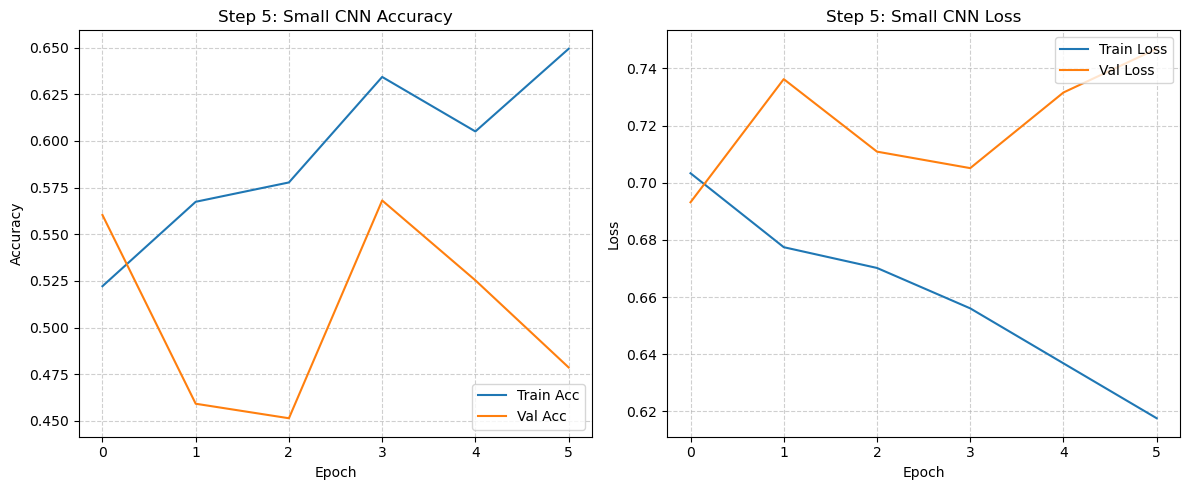

Majority Baseline Accuracy: 0.5353

Step 5 Baseline Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5116
Sensitivity          | 0.0000     | 0.8542
Specificity          | 1.0000     | 0.1858
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.50      0.19      0.27       113
   Malignant       0.57      0.85      0.69       144

    accuracy                           0.56       257
   macro avg       0.54      0.52      0.48       257
weighted avg       0.54      0.56      0.50       257



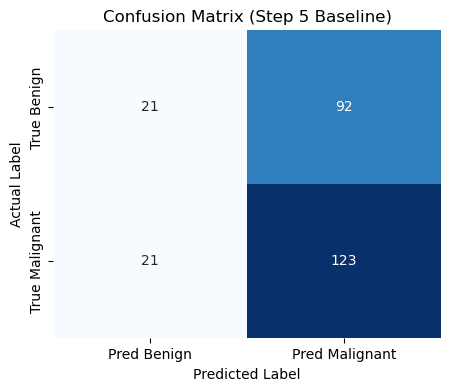

In [22]:
# Save the model
model_step5.save("step5_small_cnn_model.keras")

# Save the Training History
history_df_step5 = pd.DataFrame(history_step5.history)
history_df_step5.to_csv('step5_history.csv', index=False)

# Visualise Training Results
plot_training_history(history_step5, title_prefix="Step 5: Small CNN")

# Evaluate Performance
print(f"Majority Baseline Accuracy: {majority_baseline_acc:.4f}")

# Capture evaluation stats
stats_step5 = eval_model_perf(
    model_step5, 
    val_gen, 
    step_name="Step 5 Baseline", 
    baseline_acc=majority_baseline_acc
)

step5_summary = {
    "Step 5 Small CNN": {
        "Train Acc": history_step5.history['accuracy'][-1],
        "Val Acc": stats_step5["Val Acc"],
        "Val AUC": stats_step5["Val AUC"],
        "Sensitivity": stats_step5["Sensitivity"],
        "Specificity": stats_step5["Specificity"],
        "Gap": abs(history_step5.history['accuracy'][-1] - stats_step5["Val Acc"])
    }
}

pd.DataFrame(step5_summary).T.to_csv('step5_summary.csv')

The Small CNN exceeded the baseline accuracy (0.5603 versus 0.5353); however, the AUC-ROC of 0.5116 indicates performance only marginally better than random classification. Notably, Sensitivity reached 0.8542, substantially surpassing the Majority Baseline of 0.0000. This proves that the model can learn and validates proceeding to the next step.

# 6. Scaling up: developing a model that overfits

## 6.1 Build Overfit Model
The purpose of this model is to be intentionally over-parameterised to verify that the dataset is learnable and that the network possesses sufficient representational capacity.

In [14]:
def build_overfit_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: Flatten + High Capacity Dense
    x = layers.Flatten()(x) 
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step6 = build_overfit_model()
model_step6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       7385

### 6.1.1 Train the Model

In [15]:
# Configuration
epochs_step6 = 100

# Callbacks (Only checkpoint and no early stopping)
callbacks_step6 = [
    # Save model with highest training accuracy
    keras.callbacks.ModelCheckpoint(
        "step6_overfit_model.keras",
        # Monitor training accuracy
        monitor="accuracy",
        save_best_only=True,
        mode="max",
        verbose=0
    )
]

pbar = tqdm(total=epochs_step6, desc="Step 6 Overfit Progress")

start_time = time.time()

# Train for full 100 epochs
history_step6 = model_step6.fit(
    train_gen,
    epochs=epochs_step6,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks_step6 + [TqdmCallback(pbar)],
    verbose=0
)
pbar.close()

total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time/60:.2f} minutes")

Step 6 Overfit Progress: 100%|█| 100/100 [1:57:09<00:00, 70.29s/it, loss=0.011, 


Total time taken: 117.16 minutes


### 6.1.2 Display Plots and Metrics

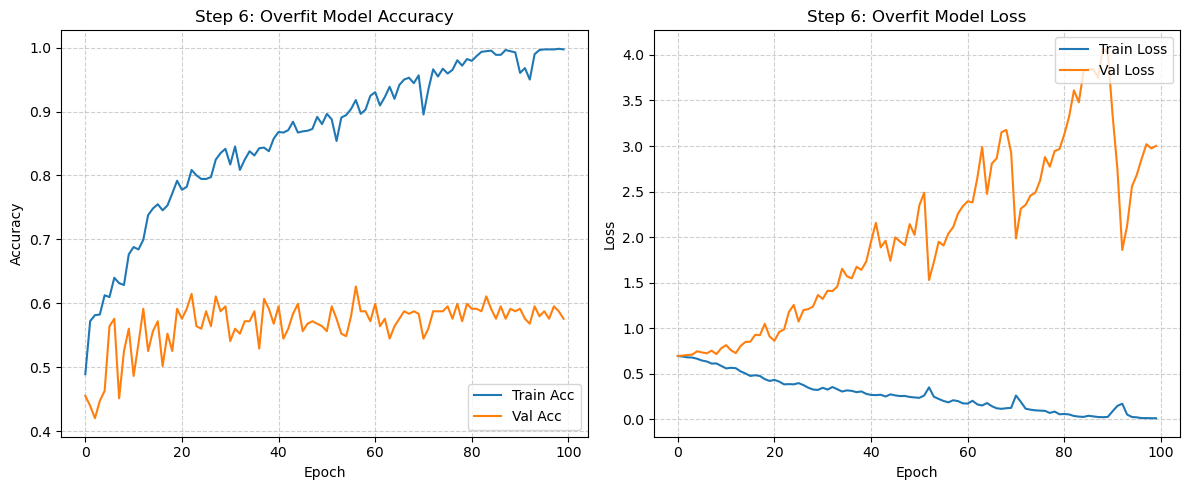


Step 6 Overfit Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5875
AUC-ROC              | 0.5000     | 0.6037
Sensitivity          | 0.0000     | 0.5694
Specificity          | 1.0000     | 0.6106
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.53      0.61      0.57       113
   Malignant       0.65      0.57      0.61       144

    accuracy                           0.59       257
   macro avg       0.59      0.59      0.59       257
weighted avg       0.60      0.59      0.59       257



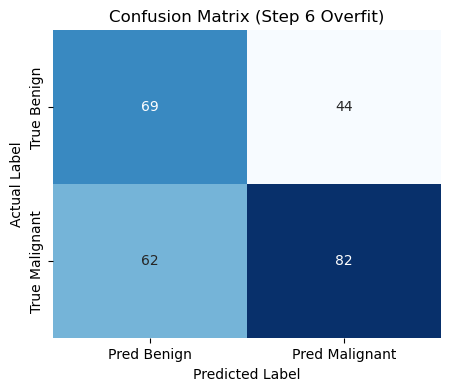

In [18]:
# Visualise the History
plot_training_history(history_step6, title_prefix="Step 6: Overfit Model")

# Load Peak Weights for the Summary Table
model_step6.load_weights("step6_overfit_model.keras")

# Evaluate and Automate the Summary
stats = eval_model_perf(model_step6, val_gen, step_name="Step 6 Overfit", baseline_acc=majority_baseline_acc)

# Use max() for Train Acc to match the loaded peak weights
peak_train_acc = max(history_step6.history['accuracy'])

step6_summary = {
    "Step 6 Overfit": {
        "Train Acc": peak_train_acc,
        "Val Acc": stats["Val Acc"],
        "Val AUC": stats["Val AUC"],
        "Sensitivity": stats["Sensitivity"],
        "Specificity": stats["Specificity"],
        "Gap": abs(peak_train_acc - stats["Val Acc"])
    }
}

The high-capacity Flatten-based CNN successfully memorised the training data, achieving near-perfect training accuracy. However, validation loss diverged significantly, confirming severe overfitting. Although validation AUC improved to 0.6037 compared to previous baselines, the large generalisation gap indicates that architectural and regularisation strategies are required to stabilise performance.

## 6.1.3 Save the Results

In [19]:
# Save everything
pd.DataFrame(step6_summary).T.to_csv('step6_overfit_summary.csv')

# Save history
history_df = pd.DataFrame(history_step6.history)
history_df.to_csv('step6_history.csv', index=False)

# Save the Model (Architecture + Peak Weights)
model_step6.save("step6_overfit_model_final.keras")

# 7 Developing a Model that Overfits (Architecture Refinement)
The objective of this section is to reduce the generalisation gap observed in Step 6 through architectural refinement, explicit regularisation techniques, and systematic hyperparameter optimisation.

In [9]:
majority_baseline_acc = max((train_gen.classes == 0).mean(), (train_gen.classes == 1).mean())

## 7.1 Capacity Control via Architectural Simplification (GAP)
The Flatten-based classification head introduces a substantial number of trainable parameters, increasing the model’s effective capacity and susceptibility to overfitting. To mitigate excessive parameterisation and encourage spatial summarisation of feature maps, the classification head was replaced with Global Average Pooling (GAP). 

Unlike traditional regularisation methods, GAP does not impose an explicit penalty on weights; instead, it reduces model complexity by structurally constraining the representation, thereby acting as an implicit form of capacity control.  

This modification was introduced prior to applying explicit regularisation techniques in order to first assess whether architectural simplification alone could stabilise validation performance. Accordingly, model checkpointing and performance monitoring were based on validation metrics rather than training accuracy, as the objective at this stage is improved generalisation rather than memorisation.

### 7.1.1 Build GAP Model

In [24]:
def build_gap_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model

model_step7_1 = build_gap_model()
model_step7_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       7385

### 7.1.2 Train the Model

In [26]:
# Configuration
epochs_step7 = 100

# Callbacks (Monitor validation performance instead of training accuracy)
callbacks_step7 = [
    keras.callbacks.ModelCheckpoint(
        "step7_gap_model.keras",
        # Changed to validation metric
        monitor="val_auc",
        save_best_only=True,
        mode="max",
        verbose=0
    )
]

pbar = tqdm(total=epochs_step7, desc="Step 7.1 GAP Progress")

start_time = time.time()

# Train for full 100 epochs (same structure as Step 6)
history_step7 = model_step7_1.fit(
    train_gen,
    epochs=epochs_step7,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks_step7 + [TqdmCallback(pbar)],
    verbose=0
)

pbar.close()

total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time/60:.2f} minutes")

Step 7.1 GAP Progress: 100%|█| 100/100 [1:52:00<00:00, 67.21s/it, loss=0.523, v_


Total time taken: 112.01 minutes


### 7.1.3 Display Plots and Metrics

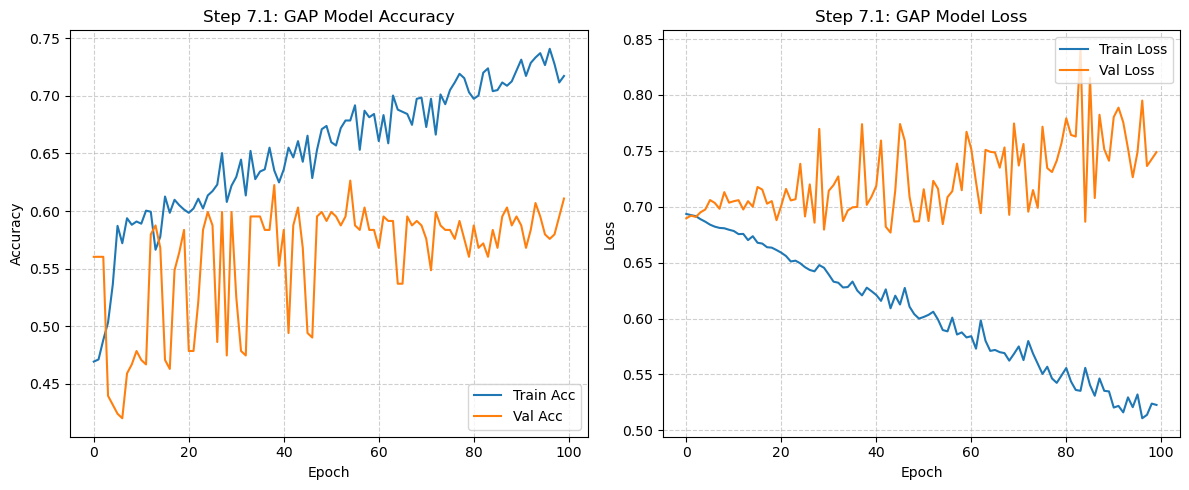


Step 7.1 GAP Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5837
AUC-ROC              | 0.5000     | 0.6618
Sensitivity          | 0.0000     | 0.7222
Specificity          | 1.0000     | 0.4071
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.53      0.41      0.46       113
   Malignant       0.61      0.72      0.66       144

    accuracy                           0.58       257
   macro avg       0.57      0.56      0.56       257
weighted avg       0.58      0.58      0.57       257



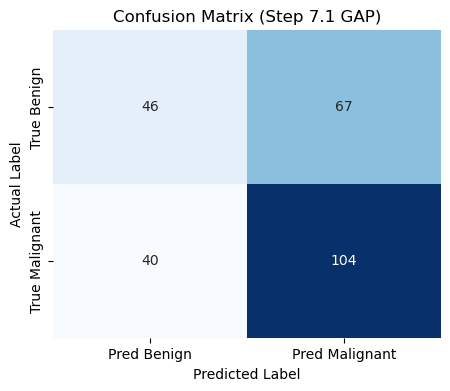

In [27]:
# Visualise the History
plot_training_history(history_step7, title_prefix="Step 7.1: GAP Model")

# Load Peak Validation Weights
model_step7_1.load_weights("step7_gap_model.keras")

# Evaluate and Automate the Summary
stats = eval_model_perf(
    model_step7_1,
    val_gen,
    step_name="Step 7.1 GAP",
    baseline_acc=majority_baseline_acc
)

best_epoch = history_step7.history['val_auc'].index(
    max(history_step7.history['val_auc'])
)

peak_train_acc = history_step7.history['accuracy'][best_epoch]

step7_summary = {
    "Step 7.1 GAP": {
        "Train Acc": peak_train_acc,
        "Val Acc": stats["Val Acc"],
        "Val AUC": stats["Val AUC"],
        "Sensitivity": stats["Sensitivity"],
        "Specificity": stats["Specificity"],
        "Gap": abs(peak_train_acc - stats["Val Acc"])
    }
}

Substituting Global Average Pooling for the Flatten-based classification head achieved a substantial parameter reduction from 14.5M to 1.57M (approximately a 9.3-fold decrease). The model no longer exhibited training accuracy approaching 100%, and validation loss stabilised across epochs, demonstrating successful mitigation of the overfitting problem observed in Step 6. Whilst validation accuracy remained relatively unchanged at approximately 0.58, validation AUC increased from 0.6037 to 0.6618, and sensitivity rose from 0.57 to 0.72, indicating enhanced malignant case detection. This suggests that constraining architectural capacity alone strengthens discriminative stability without necessitating additional regularisation mechanisms.

### 7.1.4 Save the Results

In [28]:
# Save summary
pd.DataFrame(step7_summary).T.to_csv('step7_gap_summary.csv')

# Save history
history_df = pd.DataFrame(history_step7.history)
history_df.to_csv('step7_history.csv', index=False)

# Save the Model (Architecture + Best Validation Weights)
model_step7_1.save("step7_gap_model_final.keras")

## 7.2 Training Stabilisation (Optimisation Improvements)
Improve optimisation stability without introducing regularisation techniques.  

BatchNorm (Optimisation stabilisation + faster convergence)  
EarlyStopping  
ReduceLROnPlateau  

### 7.2.1 GAP + BN (3-seed stability check)

In [8]:
def build_gap_bn_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model


Step 7.2 GAP+BN | Seed 42


Step 7.2 GAP+BN (seed42):   0%|                         | 0/100 [00:00<?, ?it/s]


Epoch 1: val_auc improved from -inf to 0.50000, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed42):   1%| | 1/100 [01:22<2:16:04, 82.47s/it, loss=0.739, v


Epoch 2: val_auc improved from 0.50000 to 0.62835, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed42):   2%| | 2/100 [02:39<2:09:48, 79.48s/it, loss=0.644, v


Epoch 3: val_auc did not improve from 0.62835


Step 7.2 GAP+BN (seed42):   3%| | 3/100 [03:57<2:06:48, 78.43s/it, loss=0.640, v


Epoch 4: val_auc did not improve from 0.62835


Step 7.2 GAP+BN (seed42):   4%| | 4/100 [05:13<2:03:57, 77.47s/it, loss=0.604, v


Epoch 5: val_auc improved from 0.62835 to 0.62912, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed42):   5%| | 5/100 [06:32<2:03:48, 78.20s/it, loss=0.617, v


Epoch 6: val_auc improved from 0.62912 to 0.63711, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed42):   6%| | 6/100 [07:54<2:04:37, 79.54s/it, loss=0.599, v


Epoch 7: val_auc did not improve from 0.63711


Step 7.2 GAP+BN (seed42):   7%| | 7/100 [09:21<2:07:00, 81.94s/it, loss=0.604, v


Epoch 8: val_auc did not improve from 0.63711


Step 7.2 GAP+BN (seed42):   8%| | 8/100 [10:47<2:07:47, 83.35s/it, loss=0.605, v


Epoch 9: val_auc improved from 0.63711 to 0.65490, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed42):   9%| | 9/100 [12:15<2:08:37, 84.81s/it, loss=0.562, v


Epoch 10: val_auc did not improve from 0.65490


Step 7.2 GAP+BN (seed42):  10%| | 10/100 [13:43<2:08:23, 85.60s/it, loss=0.561, 


Epoch 11: val_auc did not improve from 0.65490


Step 7.2 GAP+BN (seed42):  11%| | 11/100 [15:07<2:06:14, 85.10s/it, loss=0.554, 


Epoch 12: val_auc did not improve from 0.65490

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


Step 7.2 GAP+BN (seed42):  12%| | 12/100 [16:27<2:02:40, 83.65s/it, loss=0.541, 


Epoch 13: val_auc did not improve from 0.65490


Step 7.2 GAP+BN (seed42):  13%|▏| 13/100 [17:47<1:59:37, 82.49s/it, loss=0.529, 


Epoch 14: val_auc did not improve from 0.65490


Step 7.2 GAP+BN (seed42):  14%|▏| 14/100 [19:05<1:56:26, 81.24s/it, loss=0.517, 


Epoch 15: val_auc did not improve from 0.65490

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


Step 7.2 GAP+BN (seed42):  15%|▏| 15/100 [20:27<1:55:07, 81.27s/it, loss=0.509, 


Epoch 16: val_auc did not improve from 0.65490


Step 7.2 GAP+BN (seed42):  16%|▏| 16/100 [21:45<1:52:35, 80.42s/it, loss=0.509, 


Epoch 17: val_auc did not improve from 0.65490


Step 7.2 GAP+BN (seed42):  17%|▏| 17/100 [23:07<1:51:48, 80.82s/it, loss=0.486, 


Epoch 18: val_auc did not improve from 0.65490

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


Step 7.2 GAP+BN (seed42):  18%|▏| 18/100 [24:25<1:49:10, 79.89s/it, loss=0.493, 


Epoch 19: val_auc did not improve from 0.65490
Restoring model weights from the end of the best epoch: 9.


Step 7.2 GAP+BN (seed42):  19%|▏| 19/100 [25:42<1:46:52, 79.16s/it, loss=0.489, 

Epoch 19: early stopping


Step 7.2 GAP+BN (seed42):  19%|▏| 19/100 [25:42<1:49:35, 81.18s/it, loss=0.489, 

Total time taken: 25.71 minutes


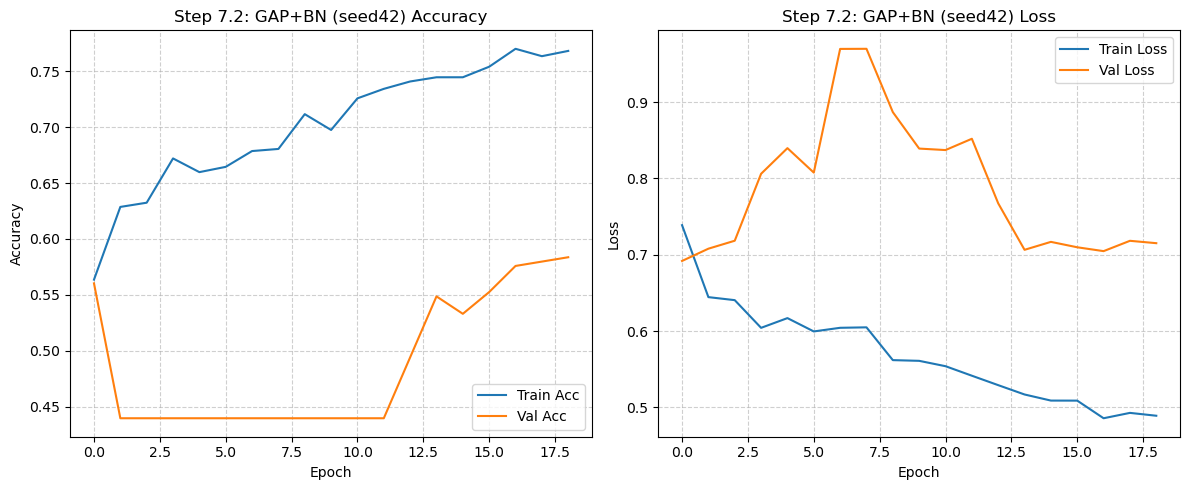


Step 7.2 GAP+BN (seed42) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.6549
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

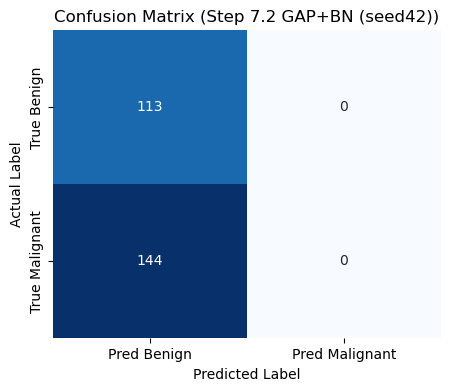


Step 7.2 GAP+BN | Seed 43


Step 7.2 GAP+BN (seed43):   0%|                         | 0/100 [00:00<?, ?it/s]


Epoch 1: val_auc improved from -inf to 0.59384, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed43):   1%| | 1/100 [01:25<2:21:41, 85.87s/it, loss=0.727, v


Epoch 2: val_auc improved from 0.59384 to 0.59839, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed43):   2%| | 2/100 [03:01<2:29:40, 91.64s/it, loss=0.642, v


Epoch 3: val_auc improved from 0.59839 to 0.60515, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed43):   3%| | 3/100 [04:29<2:25:07, 89.77s/it, loss=0.622, v


Epoch 4: val_auc improved from 0.60515 to 0.61999, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed43):   4%| | 4/100 [06:00<2:24:38, 90.40s/it, loss=0.636, v


Epoch 5: val_auc did not improve from 0.61999


Step 7.2 GAP+BN (seed43):   5%| | 5/100 [07:21<2:17:50, 87.06s/it, loss=0.622, v


Epoch 6: val_auc improved from 0.61999 to 0.62227, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed43):   6%| | 6/100 [08:40<2:11:51, 84.16s/it, loss=0.586, v


Epoch 7: val_auc did not improve from 0.62227


Step 7.2 GAP+BN (seed43):   7%| | 7/100 [09:57<2:06:58, 81.92s/it, loss=0.574, v


Epoch 8: val_auc improved from 0.62227 to 0.62737, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed43):   8%| | 8/100 [11:16<2:04:09, 80.97s/it, loss=0.577, v


Epoch 9: val_auc improved from 0.62737 to 0.65422, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed43):   9%| | 9/100 [12:36<2:02:19, 80.66s/it, loss=0.573, v


Epoch 10: val_auc did not improve from 0.65422


Step 7.2 GAP+BN (seed43):  10%| | 10/100 [13:54<1:59:51, 79.90s/it, loss=0.560, 


Epoch 11: val_auc did not improve from 0.65422


Step 7.2 GAP+BN (seed43):  11%| | 11/100 [15:11<1:57:15, 79.05s/it, loss=0.558, 


Epoch 12: val_auc did not improve from 0.65422

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


Step 7.2 GAP+BN (seed43):  12%| | 12/100 [16:28<1:55:05, 78.48s/it, loss=0.560, 


Epoch 13: val_auc did not improve from 0.65422


Step 7.2 GAP+BN (seed43):  13%|▏| 13/100 [17:45<1:53:05, 78.00s/it, loss=0.549, 


Epoch 14: val_auc did not improve from 0.65422


Step 7.2 GAP+BN (seed43):  14%|▏| 14/100 [19:06<1:52:48, 78.71s/it, loss=0.522, 


Epoch 15: val_auc did not improve from 0.65422

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


Step 7.2 GAP+BN (seed43):  15%|▏| 15/100 [20:25<1:51:58, 79.04s/it, loss=0.515, 


Epoch 16: val_auc did not improve from 0.65422


Step 7.2 GAP+BN (seed43):  16%|▏| 16/100 [21:46<1:51:28, 79.63s/it, loss=0.492, 


Epoch 17: val_auc did not improve from 0.65422


Step 7.2 GAP+BN (seed43):  17%|▏| 17/100 [23:08<1:50:59, 80.24s/it, loss=0.483, 


Epoch 18: val_auc did not improve from 0.65422

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


Step 7.2 GAP+BN (seed43):  18%|▏| 18/100 [24:30<1:50:15, 80.67s/it, loss=0.477, 


Epoch 19: val_auc did not improve from 0.65422
Restoring model weights from the end of the best epoch: 9.


Step 7.2 GAP+BN (seed43):  19%|▏| 19/100 [25:50<1:48:41, 80.51s/it, loss=0.481, 

Epoch 19: early stopping


Step 7.2 GAP+BN (seed43):  19%|▏| 19/100 [25:50<1:50:09, 81.60s/it, loss=0.481, 

Total time taken: 25.84 minutes


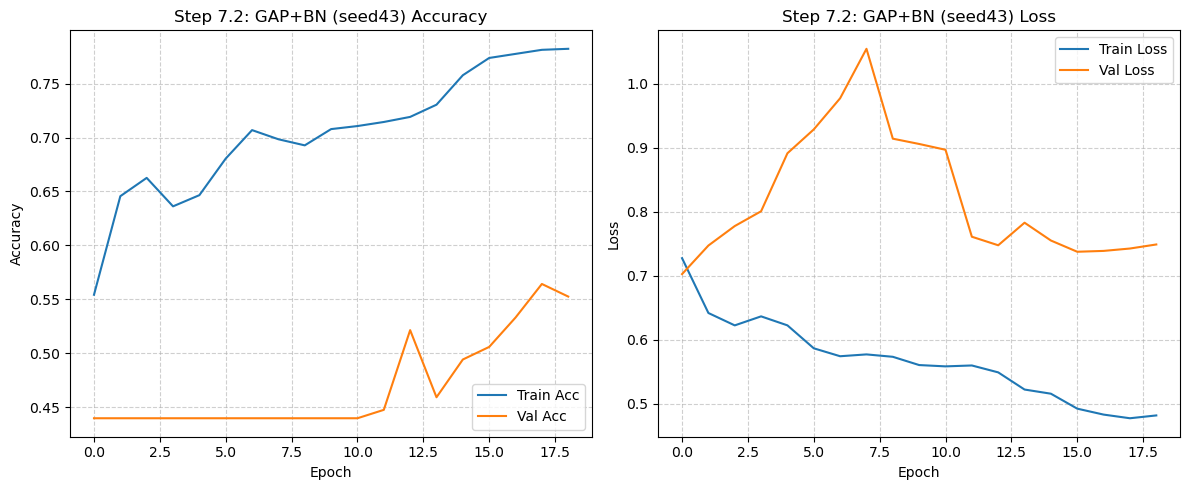


Step 7.2 GAP+BN (seed43) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.6542
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

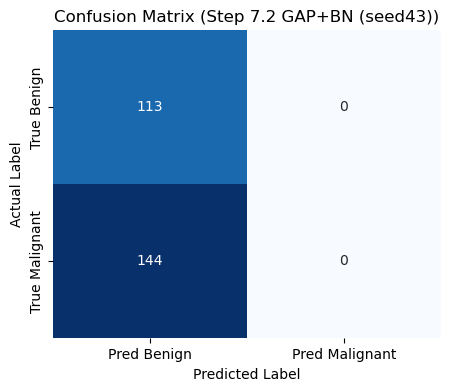


Step 7.2 GAP+BN | Seed 44


Step 7.2 GAP+BN (seed44):   0%|                         | 0/100 [00:00<?, ?it/s]


Epoch 1: val_auc improved from -inf to 0.62147, saving model to step7_gap_best.keras


Step 7.2 GAP+BN (seed44):   1%| | 1/100 [01:19<2:10:53, 79.33s/it, loss=0.712, v


Epoch 2: val_auc did not improve from 0.62147


Step 7.2 GAP+BN (seed44):   2%| | 2/100 [02:36<2:07:40, 78.17s/it, loss=0.653, v


Epoch 3: val_auc did not improve from 0.62147


Step 7.2 GAP+BN (seed44):   3%| | 3/100 [03:54<2:06:12, 78.06s/it, loss=0.629, v


Epoch 4: val_auc did not improve from 0.62147

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


Step 7.2 GAP+BN (seed44):   4%| | 4/100 [05:13<2:05:16, 78.29s/it, loss=0.628, v


Epoch 5: val_auc did not improve from 0.62147


Step 7.2 GAP+BN (seed44):   5%| | 5/100 [06:33<2:05:19, 79.16s/it, loss=0.590, v


Epoch 6: val_auc did not improve from 0.62147


Step 7.2 GAP+BN (seed44):   6%| | 6/100 [07:52<2:03:37, 78.91s/it, loss=0.574, v


Epoch 7: val_auc did not improve from 0.62147

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


Step 7.2 GAP+BN (seed44):   7%| | 7/100 [09:10<2:02:05, 78.77s/it, loss=0.577, v


Epoch 8: val_auc did not improve from 0.62147


Step 7.2 GAP+BN (seed44):   8%| | 8/100 [10:39<2:05:38, 81.94s/it, loss=0.560, v


Epoch 9: val_auc did not improve from 0.62147


Step 7.2 GAP+BN (seed44):   9%| | 9/100 [11:57<2:02:29, 80.76s/it, loss=0.553, v


Epoch 10: val_auc did not improve from 0.62147

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


Step 7.2 GAP+BN (seed44):  10%| | 10/100 [13:14<1:59:12, 79.47s/it, loss=0.552, 


Epoch 11: val_auc did not improve from 0.62147
Restoring model weights from the end of the best epoch: 1.


Step 7.2 GAP+BN (seed44):  11%| | 11/100 [14:35<1:58:29, 79.88s/it, loss=0.540, 

Epoch 11: early stopping


Step 7.2 GAP+BN (seed44):  11%| | 11/100 [14:35<1:58:00, 79.56s/it, loss=0.540, 

Total time taken: 14.59 minutes


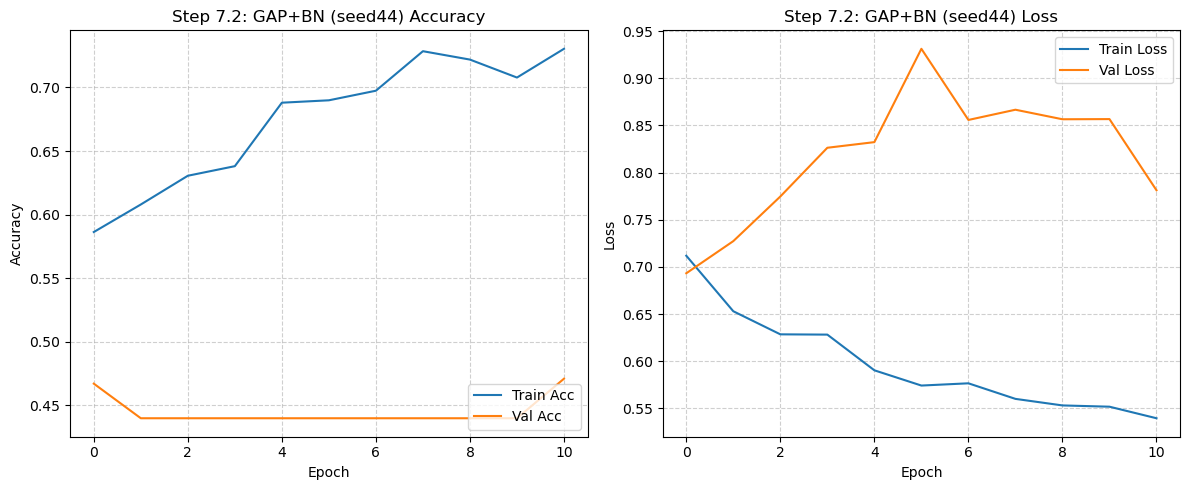


Step 7.2 GAP+BN (seed44) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4669
AUC-ROC              | 0.5000     | 0.6215
Sensitivity          | 0.0000     | 0.0486
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.45      1.00      0.62       113
   Malignant       1.00      0.05      0.09       144

    accuracy                           0.47       257
   macro avg       0.73      0.52      0.36       257
weighted avg       0.76      0.47      0.33       257



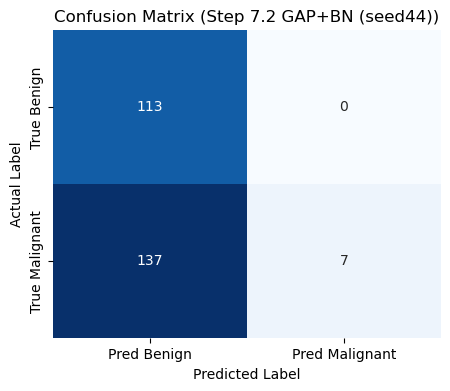

In [13]:
epochs_step7 = 100
seeds = [42, 43, 44]

all_runs = []

for seed in seeds:
    print(f"\nStep 7.2 GAP+BN | Seed {seed}")
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = build_gap_bn_model()

    run_tag = f"seed{seed}"
    ckpt_path = "step7_gap_best.keras"

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    checkpoint = keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_auc",
        save_best_only=True,
        save_weights_only=False,  # save full model
        mode="max",
        verbose=1
    )

    callbacks = [checkpoint, early_stopping, reduce_on_plateau]

    pbar = tqdm(total=epochs_step7, desc=f"Step 7.2 GAP+BN ({run_tag})")
    start_time = time.time()

    history = model.fit(
        train_gen,
        epochs=epochs_step7,
        validation_data=val_gen,
        class_weight=class_weights_dict,
        callbacks=callbacks + [TqdmCallback(pbar)],
        verbose=0
    )

    pbar.close()
    total_time = time.time() - start_time
    print(f"Total time taken: {total_time/60:.2f} minutes")

    plot_training_history(history, title_prefix=f"Step 7.2: GAP+BN ({run_tag})")

    model.load_weights(ckpt_path)

    stats = eval_model_perf(
        model,
        val_gen,
        step_name=f"Step 7.2 GAP+BN ({run_tag})",
        baseline_acc=majority_baseline_acc
    )

    best_epoch = int(np.argmax(history.history["val_auc"]))
    peak_train_acc = history.history["accuracy"][best_epoch]

    run_summary = {
        "Seed": seed,
        "Best Epoch": best_epoch + 1,
        "Train Acc (best val_auc epoch)": peak_train_acc,
        "Val Acc": stats["Val Acc"],
        "Val AUC": stats["Val AUC"],
        "Sensitivity": stats["Sensitivity"],
        "Specificity": stats["Specificity"],
        "Gap": abs(peak_train_acc - stats["Val Acc"])
    }

    all_runs.append(run_summary)
    
    pd.DataFrame(history.history).to_csv(f"step7_gap_bn_history_{run_tag}.csv", index=False)
    pd.DataFrame([run_summary]).to_csv(f"step7_gap_bn_summary_{run_tag}.csv", index=False)

    model.save(f"step7_gap_bn_model_final_{run_tag}.keras")

In [14]:
# Combined stability table
stability_df = pd.DataFrame(all_runs)
stability_df.to_csv("step7_gap_bn_stability_3runs.csv", index=False)
print(stability_df)

   Seed  Best Epoch  Train Acc (best val_auc epoch)   Val Acc   Val AUC  \
0    42           9                        0.711593  0.439689  0.654898   
1    43           9                        0.692743  0.439689  0.654222   
2    44           1                        0.586239  0.466926  0.621466   

   Sensitivity  Specificity       Gap  
0     0.000000          1.0  0.271904  
1     0.000000          1.0  0.253054  
2     0.048611          1.0  0.119313  


All stabilised runs exhibited threshold collapse (sensitivity=0) despite AUC > 0.62, indicating preserved discriminative ranking but poor logit calibration under default bias initialisation.  

Across three independent seeds (42, 43, 44), the GAP+BN model consistently collapsed to predicting the majority class (benign) at the default 0.5 threshold, yielding sensitivity = 0 and specificity = 1. Despite this, validation AUC remained ~0.62–0.65, indicating preserved ranking ability but poor probability calibration. The consistent behaviour across seeds suggests the issue is systematic rather than stochastic instability. Therefore, before introducing further regularisation, the learning rate was adjusted and tested on a single seed to determine whether insufficient optimisation magnitude was causing the collapse.

In [15]:
preds = model.predict(val_gen)
print("Min:", preds.min())
print("Max:", preds.max())
print("Mean:", preds.mean())

9/9 [==============================] - 5s 515ms/step
Min: 0.49504158
Max: 0.50172216
Mean: 0.49696967


### 7.2.2 Learning rate adjustment (single seed)
Since collapse was consistent across seeds, the issue was architectural rather than stochastic.

Three different random seeds were evaluated to test robustness. Determining whether Batch Normalisation improves training stability and generalisation.

In [16]:
def build_gap_bn_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model


Step 7.2 GAP+BN | Seed 42


Step 7.2 GAP+BN:   0%|                                  | 0/100 [00:00<?, ?it/s]


Epoch 1: val_auc improved from -inf to 0.44192, saving model to step7_gap_best.keras


Step 7.2 GAP+BN:   1%| | 1/100 [01:35<2:37:10, 95.26s/it, loss=0.915, v_auc=0.44


Epoch 2: val_auc improved from 0.44192 to 0.50000, saving model to step7_gap_best.keras


Step 7.2 GAP+BN:   2%| | 2/100 [03:01<2:26:58, 89.98s/it, loss=0.667, v_auc=0.50


Epoch 3: val_auc improved from 0.50000 to 0.59811, saving model to step7_gap_best.keras


Step 7.2 GAP+BN:   3%| | 3/100 [04:19<2:16:13, 84.26s/it, loss=0.657, v_auc=0.59


Epoch 4: val_auc did not improve from 0.59811


Step 7.2 GAP+BN:   4%| | 4/100 [05:40<2:13:06, 83.19s/it, loss=0.645, v_auc=0.43


Epoch 5: val_auc did not improve from 0.59811


Step 7.2 GAP+BN:   5%| | 5/100 [07:05<2:12:28, 83.67s/it, loss=0.644, v_auc=0.51


Epoch 6: val_auc did not improve from 0.59811

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


Step 7.2 GAP+BN:   6%| | 6/100 [08:26<2:10:05, 83.04s/it, loss=0.634, v_auc=0.39


Epoch 7: val_auc did not improve from 0.59811


Step 7.2 GAP+BN:   7%| | 7/100 [09:46<2:07:01, 81.95s/it, loss=0.616, v_auc=0.58


Epoch 8: val_auc improved from 0.59811 to 0.61409, saving model to step7_gap_best.keras


Step 7.2 GAP+BN:   8%| | 8/100 [11:10<2:06:46, 82.68s/it, loss=0.604, v_auc=0.61


Epoch 9: val_auc improved from 0.61409 to 0.64460, saving model to step7_gap_best.keras


Step 7.2 GAP+BN:   9%| | 9/100 [12:33<2:05:11, 82.54s/it, loss=0.592, v_auc=0.64


Epoch 10: val_auc improved from 0.64460 to 0.65136, saving model to step7_gap_best.keras


Step 7.2 GAP+BN:  10%| | 10/100 [13:49<2:01:03, 80.70s/it, loss=0.606, v_auc=0.6


Epoch 11: val_auc did not improve from 0.65136


Step 7.2 GAP+BN:  11%| | 11/100 [15:07<1:58:34, 79.94s/it, loss=0.587, v_auc=0.6


Epoch 12: val_auc did not improve from 0.65136


Step 7.2 GAP+BN:  12%| | 12/100 [16:23<1:55:30, 78.75s/it, loss=0.590, v_auc=0.5


Epoch 13: val_auc did not improve from 0.65136

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


Step 7.2 GAP+BN:  13%|▏| 13/100 [17:40<1:53:15, 78.11s/it, loss=0.582, v_auc=0.5


Epoch 14: val_auc did not improve from 0.65136


Step 7.2 GAP+BN:  14%|▏| 14/100 [18:59<1:52:23, 78.42s/it, loss=0.574, v_auc=0.5


Epoch 15: val_auc did not improve from 0.65136


Step 7.2 GAP+BN:  15%|▏| 15/100 [20:16<1:50:29, 78.00s/it, loss=0.555, v_auc=0.5


Epoch 16: val_auc did not improve from 0.65136

Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


Step 7.2 GAP+BN:  16%|▏| 16/100 [21:32<1:48:27, 77.47s/it, loss=0.553, v_auc=0.5


Epoch 17: val_auc did not improve from 0.65136


Step 7.2 GAP+BN:  17%|▏| 17/100 [22:50<1:47:02, 77.38s/it, loss=0.526, v_auc=0.5


Epoch 18: val_auc did not improve from 0.65136


Step 7.2 GAP+BN:  18%|▏| 18/100 [24:08<1:46:18, 77.79s/it, loss=0.526, v_auc=0.5


Epoch 19: val_auc did not improve from 0.65136

Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


Step 7.2 GAP+BN:  19%|▏| 19/100 [25:26<1:44:48, 77.64s/it, loss=0.519, v_auc=0.5


Epoch 20: val_auc did not improve from 0.65136
Restoring model weights from the end of the best epoch: 10.


Step 7.2 GAP+BN:  20%|▏| 20/100 [26:42<1:43:09, 77.37s/it, loss=0.506, v_auc=0.6

Epoch 20: early stopping


Step 7.2 GAP+BN:  20%|▏| 20/100 [26:42<1:46:51, 80.14s/it, loss=0.506, v_auc=0.6

Total time taken: 26.71 minutes


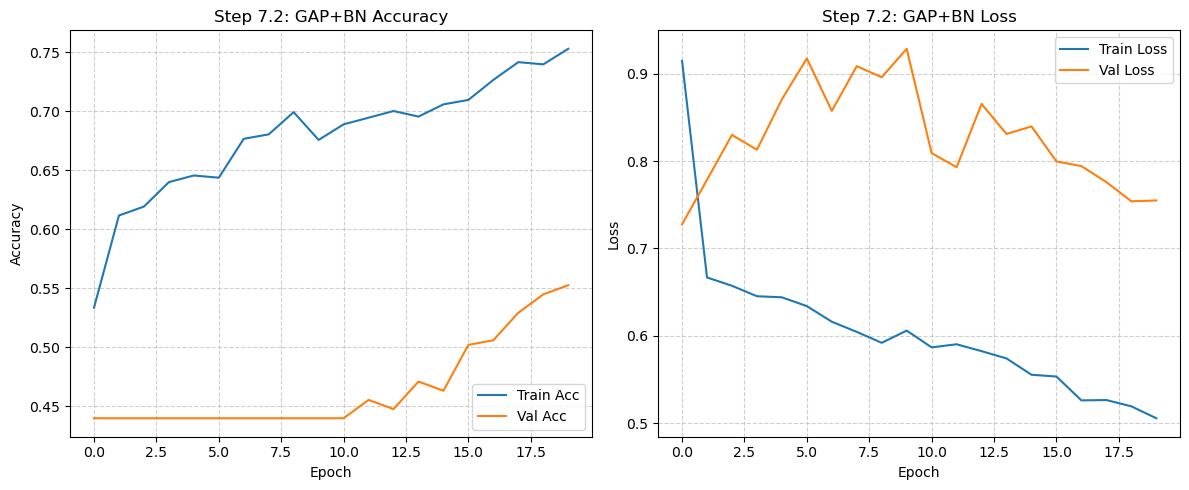


Step 7.2 GAP+BN Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.6514
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

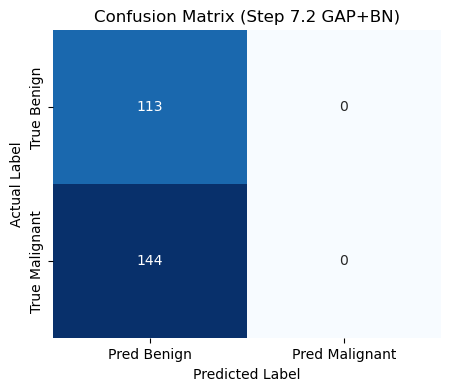

In [17]:
epochs_step7 = 100

# Optional: set ONE seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"\nStep 7.2 GAP+BN | Seed {seed}")

model = build_gap_bn_model()

ckpt_path = "step7_gap_best.keras"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor="val_auc",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_on_plateau]

pbar = tqdm(total=epochs_step7, desc="Step 7.2 GAP+BN")
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=epochs_step7,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks + [TqdmCallback(pbar)],
    verbose=0
)

pbar.close()

total_time = time.time() - start_time
print(f"Total time taken: {total_time/60:.2f} minutes")

plot_training_history(history, title_prefix="Step 7.2: GAP+BN")

model = keras.models.load_model(ckpt_path)

stats = eval_model_perf(
    model,
    val_gen,
    step_name="Step 7.2 GAP+BN",
    baseline_acc=majority_baseline_acc
)

best_epoch = int(np.argmax(history.history["val_auc"]))
peak_train_acc = history.history["accuracy"][best_epoch]

summary = {
    "Best Epoch": best_epoch + 1,
    "Train Acc (best val_auc epoch)": peak_train_acc,
    "Val Acc": stats["Val Acc"],
    "Val AUC": stats["Val AUC"],
    "Sensitivity": stats["Sensitivity"],
    "Specificity": stats["Specificity"],
    "Gap": abs(peak_train_acc - stats["Val Acc"])
}

pd.DataFrame([summary]).to_csv("step7_gap_bn_summary_lr5e4.csv", index=False)
pd.DataFrame(history.history).to_csv("step7_gap_bn_history_lr5e4.csv", index=False)

model.save("step7_gap_bn_model_final_lr5e4.keras")

Increasing the learning rate to 5e-4 did not resolve the collapse: sensitivity remained near zero while AUC stayed above 0.65. Prediction outputs were tightly clustered around 0.5 (≈0.495–0.501), confirming minimal logit separation despite preserved ranking. This indicates the issue is not under-optimisation but a logit calibration problem arising from class imbalance and default bias initialisation. Consequently, the next corrective step is to initialise the final layer bias using the class prior to address this logit bias issue.

### 7.2.2 Learning rate adjustment (single seed)
As optimisation changes did not resolve degeneracy, investigation shifted to output calibration and architecture.  

To test whether BN was suppressing signal magnitude when combined with GAP. As such LR adjusted from 1e-4 to 5e-4.

In [20]:
def build_gap_bn_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model


Step 7.2 GAP+BN | Seed 42




Step 7.2 GAP+BN:   0%|                                  | 0/100 [00:00<?, ?it/s]


Epoch 1: val_auc improved from -inf to 0.60349, saving model to step7_lr5e4_nocw_seed42_best.keras




Step 7.2 GAP+BN:   1%|▏                       | 1/100 [01:20<2:12:44, 80.45s/it]

Step 7.2 GAP+BN:   1%| | 1/100 [01:20<2:12:44, 80.45s/it, loss=0.814, v_auc=0.60

Step 7.2 GAP+BN:   1%| | 1/100 [01:20<2:12:44, 80.45s/it, loss=0.814, v_auc=0.60


Epoch 2: val_auc did not improve from 0.60349




Step 7.2 GAP+BN:   2%| | 2/100 [02:38<2:09:19, 79.18s/it, loss=0.814, v_auc=0.60

Step 7.2 GAP+BN:   2%| | 2/100 [02:38<2:09:19, 79.18s/it, loss=0.659, v_auc=0.52

Step 7.2 GAP+BN:   2%| | 2/100 [02:38<2:09:19, 79.18s/it, loss=0.659, v_auc=0.52


Epoch 3: val_auc improved from 0.60349 to 0.60371, saving model to step7_lr5e4_nocw_seed42_best.keras




Step 7.2 GAP+BN:   3%| | 3/100 [03:55<2:06:31, 78.27s/it, loss=0.659, v_auc=0.52

Step 7.2 GAP+BN:   3%| | 3/100 [03:55<2:06:31, 78.27s/it, loss=0.636, v_auc=0.60

Step 7.2 GAP+BN:   3%| | 3/100 [03:55<2:06:31, 78.27s/it, loss=0.636, v_auc=0.60


Epoch 4: val_auc did not improve from 0.60371




Step 7.2 GAP+BN:   4%| | 4/100 [05:15<2:05:53, 78.68s/it, loss=0.636, v_auc=0.60

Step 7.2 GAP+BN:   4%| | 4/100 [05:15<2:05:53, 78.68s/it, loss=0.631, v_auc=0.52

Step 7.2 GAP+BN:   4%| | 4/100 [05:15<2:05:53, 78.68s/it, loss=0.631, v_auc=0.52


Epoch 5: val_auc improved from 0.60371 to 0.60684, saving model to step7_lr5e4_nocw_seed42_best.keras




Step 7.2 GAP+BN:   5%| | 5/100 [06:34<2:04:53, 78.88s/it, loss=0.631, v_auc=0.52

Step 7.2 GAP+BN:   5%| | 5/100 [06:34<2:04:53, 78.88s/it, loss=0.642, v_auc=0.60

Step 7.2 GAP+BN:   5%| | 5/100 [06:34<2:04:53, 78.88s/it, loss=0.642, v_auc=0.60


Epoch 6: val_auc did not improve from 0.60684




Step 7.2 GAP+BN:   6%| | 6/100 [07:51<2:02:19, 78.08s/it, loss=0.642, v_auc=0.60

Step 7.2 GAP+BN:   6%| | 6/100 [07:51<2:02:19, 78.08s/it, loss=0.636, v_auc=0.60

Step 7.2 GAP+BN:   6%| | 6/100 [07:51<2:02:19, 78.08s/it, loss=0.636, v_auc=0.60


Epoch 7: val_auc did not improve from 0.60684




Step 7.2 GAP+BN:   7%| | 7/100 [09:06<1:59:54, 77.36s/it, loss=0.636, v_auc=0.60

Step 7.2 GAP+BN:   7%| | 7/100 [09:06<1:59:54, 77.36s/it, loss=0.622, v_auc=0.60

Step 7.2 GAP+BN:   7%| | 7/100 [09:06<1:59:54, 77.36s/it, loss=0.622, v_auc=0.60


Epoch 8: val_auc did not improve from 0.60684

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.




Step 7.2 GAP+BN:   8%| | 8/100 [10:23<1:58:04, 77.01s/it, loss=0.622, v_auc=0.60

Step 7.2 GAP+BN:   8%| | 8/100 [10:23<1:58:04, 77.01s/it, loss=0.633, v_auc=0.56

Step 7.2 GAP+BN:   8%| | 8/100 [10:23<1:58:04, 77.01s/it, loss=0.633, v_auc=0.56


Epoch 9: val_auc did not improve from 0.60684




Step 7.2 GAP+BN:   9%| | 9/100 [11:39<1:56:20, 76.71s/it, loss=0.633, v_auc=0.56

Step 7.2 GAP+BN:   9%| | 9/100 [11:39<1:56:20, 76.71s/it, loss=0.605, v_auc=0.60

Step 7.2 GAP+BN:   9%| | 9/100 [11:39<1:56:20, 76.71s/it, loss=0.605, v_auc=0.60


Epoch 10: val_auc did not improve from 0.60684




Step 7.2 GAP+BN:  10%| | 10/100 [12:58<1:56:16, 77.52s/it, loss=0.605, v_auc=0.6

Step 7.2 GAP+BN:  10%| | 10/100 [12:58<1:56:16, 77.52s/it, loss=0.590, v_auc=0.5

Step 7.2 GAP+BN:  10%| | 10/100 [12:58<1:56:16, 77.52s/it, loss=0.590, v_auc=0.5


Epoch 11: val_auc did not improve from 0.60684

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.




Step 7.2 GAP+BN:  11%| | 11/100 [14:14<1:54:24, 77.13s/it, loss=0.590, v_auc=0.5

Step 7.2 GAP+BN:  11%| | 11/100 [14:14<1:54:24, 77.13s/it, loss=0.588, v_auc=0.5

Step 7.2 GAP+BN:  11%| | 11/100 [14:14<1:54:24, 77.13s/it, loss=0.588, v_auc=0.5


Epoch 12: val_auc did not improve from 0.60684




Step 7.2 GAP+BN:  12%| | 12/100 [15:31<1:52:55, 76.99s/it, loss=0.588, v_auc=0.5

Step 7.2 GAP+BN:  12%| | 12/100 [15:31<1:52:55, 76.99s/it, loss=0.565, v_auc=0.5

Step 7.2 GAP+BN:  12%| | 12/100 [15:31<1:52:55, 76.99s/it, loss=0.565, v_auc=0.5


Epoch 13: val_auc did not improve from 0.60684




Step 7.2 GAP+BN:  13%|▏| 13/100 [16:47<1:51:11, 76.68s/it, loss=0.565, v_auc=0.5

Step 7.2 GAP+BN:  13%|▏| 13/100 [16:47<1:51:11, 76.68s/it, loss=0.568, v_auc=0.5

Step 7.2 GAP+BN:  13%|▏| 13/100 [16:47<1:51:11, 76.68s/it, loss=0.568, v_auc=0.5


Epoch 14: val_auc did not improve from 0.60684

Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.




Step 7.2 GAP+BN:  14%|▏| 14/100 [18:04<1:50:09, 76.85s/it, loss=0.568, v_auc=0.5

Step 7.2 GAP+BN:  14%|▏| 14/100 [18:04<1:50:09, 76.85s/it, loss=0.551, v_auc=0.5

Step 7.2 GAP+BN:  14%|▏| 14/100 [18:04<1:50:09, 76.85s/it, loss=0.551, v_auc=0.5


Epoch 15: val_auc did not improve from 0.60684
Restoring model weights from the end of the best epoch: 5.




Step 7.2 GAP+BN:  15%|▏| 15/100 [19:20<1:48:29, 76.58s/it, loss=0.551, v_auc=0.5

Step 7.2 GAP+BN:  15%|▏| 15/100 [19:20<1:48:29, 76.58s/it, loss=0.543, v_auc=0.5

Step 7.2 GAP+BN:  15%|▏| 15/100 [19:20<1:48:29, 76.58s/it, loss=0.543, v_auc=0.5

Epoch 15: early stopping


Step 7.2 GAP+BN:  15%|▏| 15/100 [19:20<1:49:36, 77.38s/it, loss=0.543, v_auc=0.5

Total time taken: 19.34 minutes


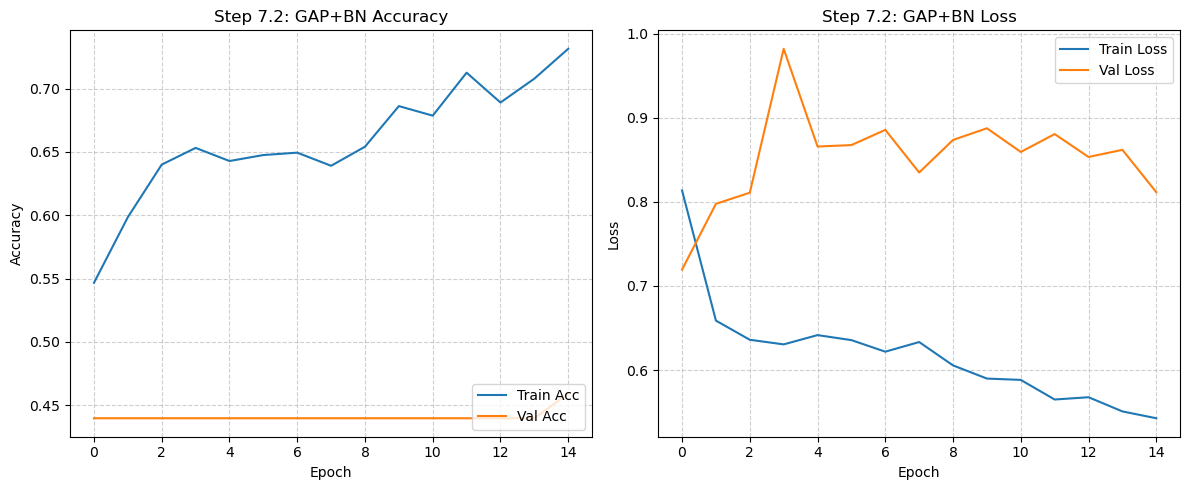

Step 7.2 GAP+BN:   3%| | 3/100 [31:33<17:00:19, 631.13s/it, loss=0.646, v_auc=0.


9/9 [==============================] - 4s 459ms/step
Pred range: 0.26936677 0.28071156 0.27317703

Step 7.2 GAP+BN Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.6068
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

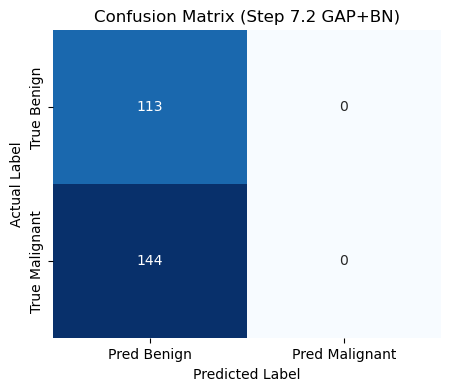

In [22]:
epochs_step7 = 100

# Optional: set ONE seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"\nStep 7.2 GAP+BN | Seed {seed}")

model = build_gap_bn_model()

run_tag = "lr5e4_nocw_seed42"
ckpt_path = f"step7_{run_tag}_best.keras"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor="val_auc",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_on_plateau]

pbar = tqdm(total=epochs_step7, desc="Step 7.2 GAP+BN")
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=epochs_step7,
    validation_data=val_gen,
    class_weight=None,
    callbacks=callbacks + [TqdmCallback(pbar)],
    verbose=0
)

pbar.close()

total_time = time.time() - start_time
print(f"Total time taken: {total_time/60:.2f} minutes")

plot_training_history(history, title_prefix="Step 7.2: GAP+BN")

model = keras.models.load_model(ckpt_path)

preds = model.predict(val_gen)
print("Pred range:", preds.min(), preds.max(), preds.mean())

stats = eval_model_perf(
    model,
    val_gen,
    step_name="Step 7.2 GAP+BN",
    baseline_acc=majority_baseline_acc
)

best_epoch = int(np.argmax(history.history["val_auc"]))
peak_train_acc = history.history["accuracy"][best_epoch]

summary = {
    "Best Epoch": best_epoch + 1,
    "Train Acc (best val_auc epoch)": peak_train_acc,
    "Val Acc": stats["Val Acc"],
    "Val AUC": stats["Val AUC"],
    "Sensitivity": stats["Sensitivity"],
    "Specificity": stats["Specificity"],
    "Gap": abs(peak_train_acc - stats["Val Acc"])
}

pd.DataFrame([summary]).to_csv(f"step7_{run_tag}_summary.csv", index=False)
pd.DataFrame(history.history).to_csv(f"step7_{run_tag}_history.csv", index=False)
model.save(f"step7_{run_tag}_final.keras")

### 7.2.4 Remove BN (single seed)
This is to test whether BN was suppressing signal magnitude when combined with GAP.

In [23]:
def build_gap_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model

model = build_gap_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 56, 56, 128)       7385


Step 7.2 GAP (no BN) | Seed 42
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)        

Step 7.2 GAP (no BN):   0%|                             | 0/100 [00:00<?, ?it/s]


Epoch 1: val_auc improved from -inf to 0.37985, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):   1%| | 1/100 [01:06<1:49:00, 66.06s/it, loss=0.693, v_auc


Epoch 2: val_auc improved from 0.37985 to 0.38766, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):   2%| | 2/100 [02:08<1:44:43, 64.12s/it, loss=0.691, v_auc


Epoch 3: val_auc improved from 0.38766 to 0.39918, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):   3%| | 3/100 [03:09<1:41:15, 62.64s/it, loss=0.691, v_auc


Epoch 4: val_auc improved from 0.39918 to 0.40751, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):   4%| | 4/100 [04:10<1:38:53, 61.81s/it, loss=0.688, v_auc


Epoch 5: val_auc did not improve from 0.40751


Step 7.2 GAP (no BN):   5%| | 5/100 [05:10<1:36:51, 61.18s/it, loss=0.687, v_auc


Epoch 6: val_auc improved from 0.40751 to 0.41166, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):   6%| | 6/100 [06:10<1:35:17, 60.83s/it, loss=0.684, v_auc


Epoch 7: val_auc did not improve from 0.41166


Step 7.2 GAP (no BN):   7%| | 7/100 [07:10<1:33:48, 60.52s/it, loss=0.681, v_auc


Epoch 8: val_auc improved from 0.41166 to 0.42346, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):   8%| | 8/100 [08:10<1:32:32, 60.36s/it, loss=0.680, v_auc


Epoch 9: val_auc improved from 0.42346 to 0.43529, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):   9%| | 9/100 [09:21<1:36:46, 63.81s/it, loss=0.678, v_auc


Epoch 10: val_auc improved from 0.43529 to 0.48178, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  10%| | 10/100 [10:35<1:40:29, 66.99s/it, loss=0.676, v_au


Epoch 11: val_auc improved from 0.48178 to 0.50568, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  11%| | 11/100 [11:46<1:41:12, 68.23s/it, loss=0.673, v_au


Epoch 12: val_auc did not improve from 0.50568


Step 7.2 GAP (no BN):  12%| | 12/100 [12:49<1:37:35, 66.54s/it, loss=0.671, v_au


Epoch 13: val_auc did not improve from 0.50568


Step 7.2 GAP (no BN):  13%|▏| 13/100 [13:51<1:34:21, 65.07s/it, loss=0.677, v_au


Epoch 14: val_auc improved from 0.50568 to 0.50971, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  14%|▏| 14/100 [14:53<1:31:50, 64.08s/it, loss=0.668, v_au


Epoch 15: val_auc improved from 0.50971 to 0.51721, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  15%|▏| 15/100 [15:56<1:30:26, 63.84s/it, loss=0.667, v_au


Epoch 16: val_auc improved from 0.51721 to 0.52197, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  16%|▏| 16/100 [16:58<1:28:32, 63.25s/it, loss=0.662, v_au


Epoch 17: val_auc improved from 0.52197 to 0.52667, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  17%|▏| 17/100 [18:02<1:28:05, 63.68s/it, loss=0.661, v_au


Epoch 18: val_auc improved from 0.52667 to 0.54671, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  18%|▏| 18/100 [19:07<1:27:36, 64.10s/it, loss=0.658, v_au


Epoch 19: val_auc did not improve from 0.54671


Step 7.2 GAP (no BN):  19%|▏| 19/100 [20:10<1:25:54, 63.63s/it, loss=0.658, v_au


Epoch 20: val_auc improved from 0.54671 to 0.55049, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  20%|▏| 20/100 [21:12<1:24:06, 63.08s/it, loss=0.653, v_au


Epoch 21: val_auc did not improve from 0.55049


Step 7.2 GAP (no BN):  21%|▏| 21/100 [22:15<1:23:06, 63.12s/it, loss=0.653, v_au


Epoch 22: val_auc did not improve from 0.55049


Step 7.2 GAP (no BN):  22%|▏| 22/100 [23:17<1:21:34, 62.75s/it, loss=0.649, v_au


Epoch 23: val_auc improved from 0.55049 to 0.55768, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  23%|▏| 23/100 [24:19<1:20:27, 62.70s/it, loss=0.655, v_au


Epoch 24: val_auc did not improve from 0.55768


Step 7.2 GAP (no BN):  24%|▏| 24/100 [25:22<1:19:26, 62.72s/it, loss=0.650, v_au


Epoch 25: val_auc did not improve from 0.55768


Step 7.2 GAP (no BN):  25%|▎| 25/100 [26:25<1:18:13, 62.58s/it, loss=0.648, v_au


Epoch 26: val_auc improved from 0.55768 to 0.56373, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  26%|▎| 26/100 [27:27<1:17:19, 62.69s/it, loss=0.652, v_au


Epoch 27: val_auc improved from 0.56373 to 0.57178, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  27%|▎| 27/100 [28:29<1:15:50, 62.33s/it, loss=0.643, v_au


Epoch 28: val_auc did not improve from 0.57178


Step 7.2 GAP (no BN):  28%|▎| 28/100 [29:32<1:15:11, 62.66s/it, loss=0.639, v_au


Epoch 29: val_auc did not improve from 0.57178


Step 7.2 GAP (no BN):  29%|▎| 29/100 [30:35<1:14:12, 62.71s/it, loss=0.637, v_au


Epoch 30: val_auc improved from 0.57178 to 0.59808, saving model to step7_gap_noBN_lr1e4_nocw_seed42_best.keras


Step 7.2 GAP (no BN):  30%|▎| 30/100 [31:37<1:12:58, 62.56s/it, loss=0.649, v_au


Epoch 31: val_auc did not improve from 0.59808


Step 7.2 GAP (no BN):  31%|▎| 31/100 [32:41<1:12:08, 62.73s/it, loss=0.647, v_au


Epoch 32: val_auc did not improve from 0.59808


Step 7.2 GAP (no BN):  32%|▎| 32/100 [33:42<1:10:48, 62.47s/it, loss=0.638, v_au


Epoch 33: val_auc did not improve from 0.59808

Epoch 33: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


Step 7.2 GAP (no BN):  33%|▎| 33/100 [34:44<1:09:31, 62.26s/it, loss=0.635, v_au


Epoch 34: val_auc did not improve from 0.59808


Step 7.2 GAP (no BN):  34%|▎| 34/100 [35:47<1:08:44, 62.49s/it, loss=0.631, v_au


Epoch 35: val_auc did not improve from 0.59808


Step 7.2 GAP (no BN):  35%|▎| 35/100 [36:50<1:07:46, 62.56s/it, loss=0.627, v_au


Epoch 36: val_auc did not improve from 0.59808

Epoch 36: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


Step 7.2 GAP (no BN):  36%|▎| 36/100 [37:52<1:06:34, 62.41s/it, loss=0.624, v_au


Epoch 37: val_auc did not improve from 0.59808


Step 7.2 GAP (no BN):  37%|▎| 37/100 [38:56<1:06:06, 62.96s/it, loss=0.621, v_au


Epoch 38: val_auc did not improve from 0.59808


Step 7.2 GAP (no BN):  38%|▍| 38/100 [39:58<1:04:45, 62.67s/it, loss=0.621, v_au


Epoch 39: val_auc did not improve from 0.59808

Epoch 39: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


Step 7.2 GAP (no BN):  39%|▍| 39/100 [41:00<1:03:28, 62.43s/it, loss=0.621, v_au


Epoch 40: val_auc did not improve from 0.59808
Restoring model weights from the end of the best epoch: 30.


Step 7.2 GAP (no BN):  40%|▍| 40/100 [42:02<1:02:18, 62.30s/it, loss=0.621, v_au

Epoch 40: early stopping


Step 7.2 GAP (no BN):  40%|▍| 40/100 [42:02<1:03:03, 63.06s/it, loss=0.621, v_au

Total time taken: 42.04 minutes


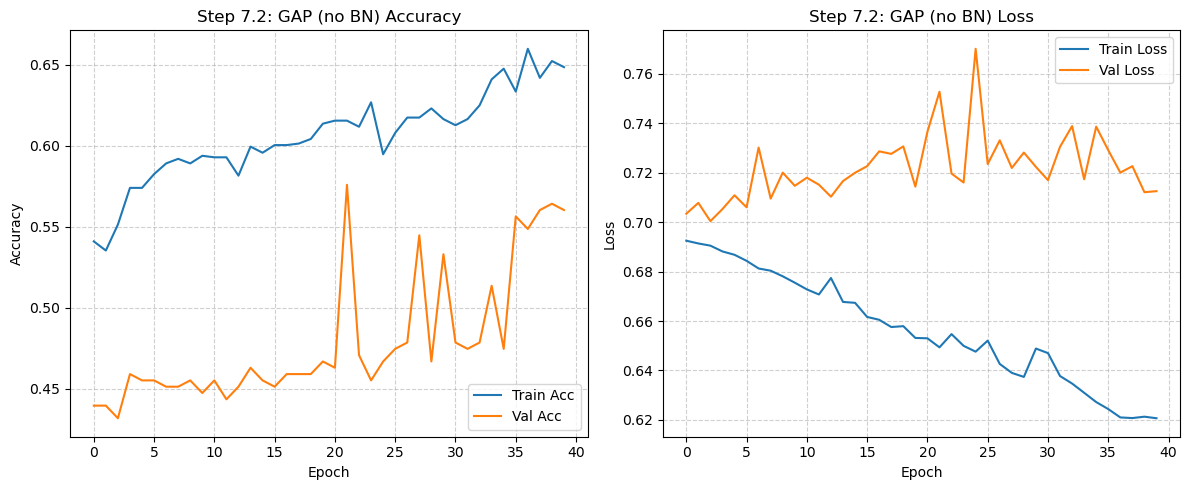

9/9 [==============================] - 4s 451ms/step
Pred range: 0.057152186 0.69900256 0.4312552

Step 7.2 GAP (no BN) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5331
AUC-ROC              | 0.5000     | 0.5981
Sensitivity          | 0.0000     | 0.2847
Specificity          | 1.0000     | 0.8496
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.48      0.85      0.62       113
   Malignant       0.71      0.28      0.41       144

    accuracy                           0.53       257
   macro avg       0.59      0.57      0.51       257
weighted avg       0.61      0.53      0.50       257



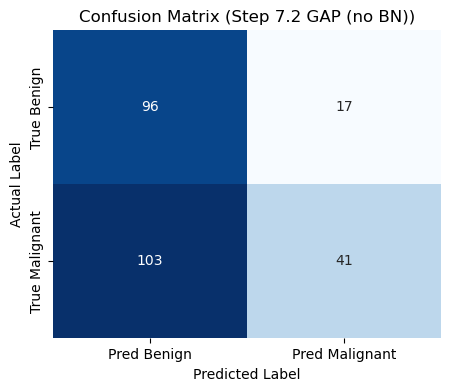

In [24]:
epochs_step7 = 100

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"\nStep 7.2 GAP (no BN) | Seed {seed}")

model = build_gap_model()
model.summary()

run_tag = "gap_noBN_lr1e4_nocw_seed42"
ckpt_path = f"step7_{run_tag}_best.keras"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor="val_auc",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_on_plateau]

pbar = tqdm(total=epochs_step7, desc="Step 7.2 GAP (no BN)")
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=epochs_step7,
    validation_data=val_gen,
    class_weight=None,
    callbacks=callbacks + [TqdmCallback(pbar)],
    verbose=0
)

pbar.close()

total_time = time.time() - start_time
print(f"Total time taken: {total_time/60:.2f} minutes")

plot_training_history(history, title_prefix="Step 7.2: GAP (no BN)")

model = keras.models.load_model(ckpt_path)

preds = model.predict(val_gen)
print("Pred range:", preds.min(), preds.max(), preds.mean())

stats = eval_model_perf(
    model,
    val_gen,
    step_name="Step 7.2 GAP (no BN)",
    baseline_acc=majority_baseline_acc
)

best_epoch = int(np.argmax(history.history["val_auc"]))
peak_train_acc = history.history["accuracy"][best_epoch]

summary = {
    "Best Epoch": best_epoch + 1,
    "Train Acc (best val_auc epoch)": peak_train_acc,
    "Val Acc": stats["Val Acc"],
    "Val AUC": stats["Val AUC"],
    "Sensitivity": stats["Sensitivity"],
    "Specificity": stats["Specificity"],
    "Gap": abs(peak_train_acc - stats["Val Acc"])
}

pd.DataFrame([summary]).to_csv(f"step7_{run_tag}_summary.csv", index=False)
pd.DataFrame(history.history).to_csv(f"step7_{run_tag}_history.csv", index=False)
model.save(f"step7_{run_tag}_final.keras")

## 7.3 Capacity Adjustment

In [25]:
def build_dense_gap_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    # Dense layer to add parameters to interpret GAP features and reduce underfitting
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model


Step 7.3 Dense+GAP
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 56

Training 7.3:   0%|                                     | 0/100 [00:00<?, ?it/s]


Epoch 1: val_auc improved from -inf to 0.38726, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:   1%| | 1/100 [01:01<1:40:53, 61.15s/it, loss=0.693, v_auc=0.387, 


Epoch 2: val_auc did not improve from 0.38726


Training 7.3:   2%| | 2/100 [02:01<1:38:56, 60.57s/it, loss=0.692, v_auc=0.383, 


Epoch 3: val_auc improved from 0.38726 to 0.40361, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:   3%| | 3/100 [03:02<1:38:26, 60.89s/it, loss=0.691, v_auc=0.404, 


Epoch 4: val_auc did not improve from 0.40361


Training 7.3:   4%| | 4/100 [04:02<1:37:04, 60.67s/it, loss=0.688, v_auc=0.397, 


Epoch 5: val_auc improved from 0.40361 to 0.42506, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:   5%| | 5/100 [05:03<1:35:43, 60.46s/it, loss=0.685, v_auc=0.425, 


Epoch 6: val_auc did not improve from 0.42506


Training 7.3:   6%| | 6/100 [06:03<1:34:34, 60.37s/it, loss=0.683, v_auc=0.403, 


Epoch 7: val_auc did not improve from 0.42506


Training 7.3:   7%| | 7/100 [07:03<1:33:20, 60.22s/it, loss=0.681, v_auc=0.414, 


Epoch 8: val_auc improved from 0.42506 to 0.44789, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:   8%| | 8/100 [08:03<1:32:25, 60.28s/it, loss=0.678, v_auc=0.448, 


Epoch 9: val_auc improved from 0.44789 to 0.47069, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:   9%| | 9/100 [09:03<1:31:29, 60.33s/it, loss=0.679, v_auc=0.471, 


Epoch 10: val_auc did not improve from 0.47069


Training 7.3:  10%| | 10/100 [10:04<1:30:34, 60.38s/it, loss=0.674, v_auc=0.458,


Epoch 11: val_auc improved from 0.47069 to 0.50611, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  11%| | 11/100 [11:04<1:29:18, 60.21s/it, loss=0.671, v_auc=0.506,


Epoch 12: val_auc improved from 0.50611 to 0.51564, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  12%| | 12/100 [12:04<1:28:11, 60.14s/it, loss=0.671, v_auc=0.516,


Epoch 13: val_auc improved from 0.51564 to 0.51696, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  13%|▏| 13/100 [13:04<1:27:17, 60.20s/it, loss=0.671, v_auc=0.517,


Epoch 14: val_auc did not improve from 0.51696


Training 7.3:  14%|▏| 14/100 [14:04<1:26:17, 60.20s/it, loss=0.665, v_auc=0.515,


Epoch 15: val_auc improved from 0.51696 to 0.53199, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  15%|▏| 15/100 [15:05<1:25:33, 60.40s/it, loss=0.661, v_auc=0.532,


Epoch 16: val_auc did not improve from 0.53199


Training 7.3:  16%|▏| 16/100 [16:05<1:24:30, 60.36s/it, loss=0.666, v_auc=0.503,


Epoch 17: val_auc did not improve from 0.53199


Training 7.3:  17%|▏| 17/100 [17:05<1:23:08, 60.11s/it, loss=0.662, v_auc=0.511,


Epoch 18: val_auc did not improve from 0.53199

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


Training 7.3:  18%|▏| 18/100 [18:05<1:22:00, 60.00s/it, loss=0.661, v_auc=0.530,


Epoch 19: val_auc did not improve from 0.53199


Training 7.3:  19%|▏| 19/100 [19:04<1:20:49, 59.88s/it, loss=0.653, v_auc=0.529,


Epoch 20: val_auc improved from 0.53199 to 0.53792, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  20%|▏| 20/100 [20:04<1:19:53, 59.92s/it, loss=0.653, v_auc=0.538,


Epoch 21: val_auc improved from 0.53792 to 0.54031, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  21%|▏| 21/100 [21:05<1:19:06, 60.08s/it, loss=0.649, v_auc=0.540,


Epoch 22: val_auc improved from 0.54031 to 0.55224, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  22%|▏| 22/100 [22:06<1:18:24, 60.31s/it, loss=0.646, v_auc=0.552,


Epoch 23: val_auc improved from 0.55224 to 0.56044, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  23%|▏| 23/100 [23:06<1:17:19, 60.26s/it, loss=0.649, v_auc=0.560,


Epoch 24: val_auc did not improve from 0.56044


Training 7.3:  24%|▏| 24/100 [24:06<1:16:14, 60.19s/it, loss=0.644, v_auc=0.553,


Epoch 25: val_auc improved from 0.56044 to 0.56087, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  25%|▎| 25/100 [25:06<1:15:04, 60.06s/it, loss=0.646, v_auc=0.561,


Epoch 26: val_auc improved from 0.56087 to 0.56987, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  26%|▎| 26/100 [26:07<1:14:44, 60.60s/it, loss=0.643, v_auc=0.570,


Epoch 27: val_auc did not improve from 0.56987


Training 7.3:  27%|▎| 27/100 [27:08<1:13:49, 60.68s/it, loss=0.645, v_auc=0.560,


Epoch 28: val_auc improved from 0.56987 to 0.57599, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  28%|▎| 28/100 [28:09<1:12:58, 60.82s/it, loss=0.641, v_auc=0.576,


Epoch 29: val_auc improved from 0.57599 to 0.57753, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  29%|▎| 29/100 [29:10<1:12:03, 60.90s/it, loss=0.638, v_auc=0.578,


Epoch 30: val_auc improved from 0.57753 to 0.57992, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  30%|▎| 30/100 [30:12<1:11:15, 61.07s/it, loss=0.638, v_auc=0.580,


Epoch 31: val_auc did not improve from 0.57992


Training 7.3:  31%|▎| 31/100 [31:13<1:10:08, 60.99s/it, loss=0.644, v_auc=0.580,


Epoch 32: val_auc improved from 0.57992 to 0.58140, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  32%|▎| 32/100 [32:14<1:09:15, 61.12s/it, loss=0.633, v_auc=0.581,


Epoch 33: val_auc did not improve from 0.58140


Training 7.3:  33%|▎| 33/100 [33:14<1:07:51, 60.77s/it, loss=0.634, v_auc=0.580,


Epoch 34: val_auc improved from 0.58140 to 0.58622, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  34%|▎| 34/100 [34:14<1:06:34, 60.53s/it, loss=0.627, v_auc=0.586,


Epoch 35: val_auc did not improve from 0.58622


Training 7.3:  35%|▎| 35/100 [35:14<1:05:19, 60.30s/it, loss=0.629, v_auc=0.576,


Epoch 36: val_auc did not improve from 0.58622


Training 7.3:  36%|▎| 36/100 [36:14<1:04:14, 60.23s/it, loss=0.628, v_auc=0.570,


Epoch 37: val_auc improved from 0.58622 to 0.59556, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  37%|▎| 37/100 [37:13<1:03:02, 60.03s/it, loss=0.627, v_auc=0.596,


Epoch 38: val_auc did not improve from 0.59556


Training 7.3:  38%|▍| 38/100 [38:14<1:02:08, 60.14s/it, loss=0.623, v_auc=0.577,


Epoch 39: val_auc did not improve from 0.59556


Training 7.3:  39%|▍| 39/100 [39:14<1:01:01, 60.02s/it, loss=0.624, v_auc=0.587,


Epoch 40: val_auc improved from 0.59556 to 0.60245, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  40%|▍| 40/100 [40:14<1:00:04, 60.07s/it, loss=0.623, v_auc=0.602,


Epoch 41: val_auc did not improve from 0.60245


Training 7.3:  41%|▍| 41/100 [41:14<59:03, 60.06s/it, loss=0.626, v_auc=0.587, g


Epoch 42: val_auc did not improve from 0.60245


Training 7.3:  42%|▍| 42/100 [42:14<58:06, 60.11s/it, loss=0.624, v_auc=0.588, g


Epoch 43: val_auc did not improve from 0.60245

Epoch 43: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


Training 7.3:  43%|▍| 43/100 [43:14<57:00, 60.01s/it, loss=0.622, v_auc=0.598, g


Epoch 44: val_auc did not improve from 0.60245


Training 7.3:  44%|▍| 44/100 [44:14<55:59, 59.99s/it, loss=0.614, v_auc=0.601, g


Epoch 45: val_auc did not improve from 0.60245


Training 7.3:  45%|▍| 45/100 [45:13<54:51, 59.85s/it, loss=0.614, v_auc=0.597, g


Epoch 46: val_auc did not improve from 0.60245

Epoch 46: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


Training 7.3:  46%|▍| 46/100 [46:13<53:53, 59.87s/it, loss=0.612, v_auc=0.593, g


Epoch 47: val_auc did not improve from 0.60245


Training 7.3:  47%|▍| 47/100 [47:13<52:55, 59.92s/it, loss=0.609, v_auc=0.595, g


Epoch 48: val_auc did not improve from 0.60245


Training 7.3:  48%|▍| 48/100 [48:13<51:56, 59.93s/it, loss=0.609, v_auc=0.599, g


Epoch 49: val_auc improved from 0.60245 to 0.60248, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras

Epoch 49: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.


Training 7.3:  49%|▍| 49/100 [49:14<51:04, 60.09s/it, loss=0.608, v_auc=0.602, g


Epoch 50: val_auc did not improve from 0.60248


Training 7.3:  50%|▌| 50/100 [50:14<50:08, 60.17s/it, loss=0.609, v_auc=0.601, g


Epoch 51: val_auc did not improve from 0.60248


Training 7.3:  51%|▌| 51/100 [51:16<49:29, 60.60s/it, loss=0.607, v_auc=0.601, g


Epoch 52: val_auc did not improve from 0.60248

Epoch 52: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.


Training 7.3:  52%|▌| 52/100 [52:22<49:56, 62.42s/it, loss=0.607, v_auc=0.599, g


Epoch 53: val_auc did not improve from 0.60248


Training 7.3:  53%|▌| 53/100 [53:26<49:11, 62.79s/it, loss=0.607, v_auc=0.600, g


Epoch 54: val_auc did not improve from 0.60248


Training 7.3:  54%|▌| 54/100 [54:27<47:49, 62.38s/it, loss=0.605, v_auc=0.600, g


Epoch 55: val_auc improved from 0.60248 to 0.60358, saving model to step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras


Training 7.3:  55%|▌| 55/100 [55:28<46:28, 61.97s/it, loss=0.606, v_auc=0.604, g


Epoch 56: val_auc did not improve from 0.60358


Training 7.3:  56%|▌| 56/100 [56:32<45:53, 62.59s/it, loss=0.606, v_auc=0.601, g


Epoch 57: val_auc did not improve from 0.60358


Training 7.3:  57%|▌| 57/100 [57:34<44:37, 62.26s/it, loss=0.606, v_auc=0.600, g


Epoch 58: val_auc did not improve from 0.60358

Epoch 58: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.


Training 7.3:  58%|▌| 58/100 [58:34<43:11, 61.69s/it, loss=0.605, v_auc=0.602, g


Epoch 59: val_auc did not improve from 0.60358


Training 7.3:  59%|▌| 59/100 [59:35<41:55, 61.35s/it, loss=0.605, v_auc=0.602, g


Epoch 60: val_auc did not improve from 0.60358


Training 7.3:  60%|▌| 60/100 [1:00:35<40:43, 61.08s/it, loss=0.605, v_auc=0.603,


Epoch 61: val_auc did not improve from 0.60358

Epoch 61: ReduceLROnPlateau reducing learning rate to 1e-06.


Training 7.3:  61%|▌| 61/100 [1:01:35<39:30, 60.78s/it, loss=0.605, v_auc=0.603,


Epoch 62: val_auc did not improve from 0.60358


Training 7.3:  62%|▌| 62/100 [1:02:35<38:21, 60.58s/it, loss=0.605, v_auc=0.603,


Epoch 63: val_auc did not improve from 0.60358


Training 7.3:  63%|▋| 63/100 [1:03:36<37:16, 60.45s/it, loss=0.605, v_auc=0.602,


Epoch 64: val_auc did not improve from 0.60358


Training 7.3:  64%|▋| 64/100 [1:04:36<36:17, 60.48s/it, loss=0.604, v_auc=0.602,


Epoch 65: val_auc did not improve from 0.60358
Restoring model weights from the end of the best epoch: 55.


Training 7.3:  65%|▋| 65/100 [1:05:37<35:21, 60.61s/it, loss=0.604, v_auc=0.603,

Epoch 65: early stopping


Training 7.3:  65%|▋| 65/100 [1:05:37<35:20, 60.58s/it, loss=0.604, v_auc=0.603,

Total time taken: 65.63 minutes


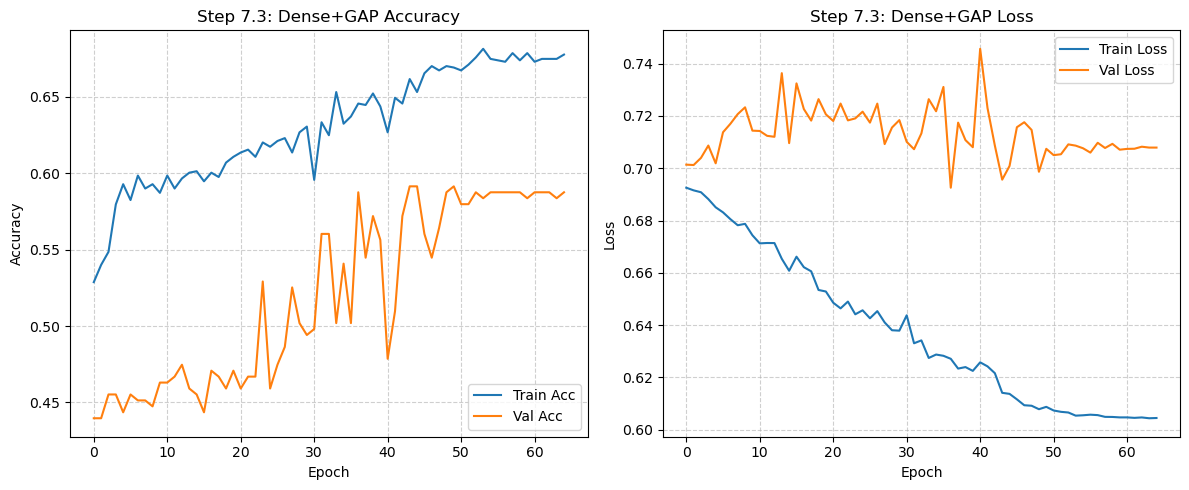


Step 7.3 Capacity Check Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5875
AUC-ROC              | 0.5000     | 0.6036
Sensitivity          | 0.0000     | 0.5417
Specificity          | 1.0000     | 0.6460
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.53      0.65      0.58       113
   Malignant       0.66      0.54      0.60       144

    accuracy                           0.59       257
   macro avg       0.59      0.59      0.59       257
weighted avg       0.60      0.59      0.59       257



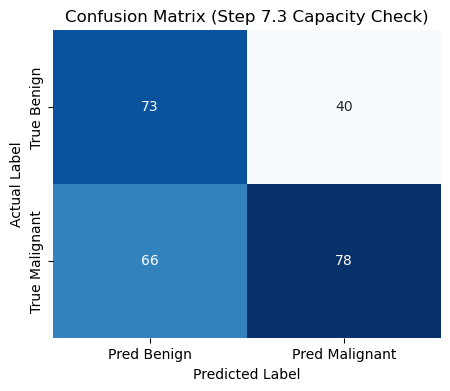

In [26]:
epochs_step7_3 = 100

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"\nStep 7.3 Dense+GAP")

model = build_dense_gap_model()
model.summary()

step_id = "7.3"
run_tag = f"step{step_id}_dense64_gap_noBN_lr1e4_nocw_seed{seed}"
ckpt_path = f"{run_tag}_best.keras"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor="val_auc",
    save_best_only=True,
    mode="max",
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_on_plateau]

pbar = tqdm(total=epochs_step7_3, desc=f"Training {step_id}")
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=epochs_step7_3,
    validation_data=val_gen,
    class_weight=None,
    callbacks=callbacks + [TqdmCallback(pbar)],
    verbose=0
)

pbar.close()

total_time = time.time() - start_time
print(f"Total time taken: {total_time/60:.2f} minutes")

plot_training_history(history, title_prefix=f"Step {step_id}: Dense+GAP")

model = keras.models.load_model(ckpt_path)

stats = eval_model_perf(
    model,
    val_gen,
    step_name=f"Step {step_id} Capacity Check",
    baseline_acc=majority_baseline_acc
)

best_epoch = int(np.argmax(history.history["val_auc"]))
peak_train_acc = history.history["accuracy"][best_epoch]

summary = {
    "Best Epoch": best_epoch + 1,
    "Train Acc (best val_auc epoch)": peak_train_acc,
    "Val Acc": stats["Val Acc"],
    "Val AUC": stats["Val AUC"],
    "Sensitivity": stats["Sensitivity"],
    "Specificity": stats["Specificity"],
    "Gap": abs(peak_train_acc - stats["Val Acc"])
}

pd.DataFrame([summary]).to_csv(f"{run_tag}_summary.csv", index=False)
pd.DataFrame(history.history).to_csv(f"{run_tag}_history.csv", index=False)
model.save(f"{run_tag}_final.keras")

The GAP-only model demonstrated underfitting characteristics, reflected in low sensitivity. Introducing a modest Dense(64) layer following GAP enhanced the classification head's capacity, yielding improvements in both validation accuracy and sensitivity (malignant recall). This outcome suggests that a lightweight classification head is advantageous for this dataset. The configuration is now established as the baseline for subsequent regularisation investigations, specifically dropout experiments.

In [27]:
preds = model.predict(val_gen)
print("Pred range:", preds.min(), preds.max(), preds.mean())

9/9 [==============================] - 4s 457ms/step
Pred range: 0.048693202 0.8921049 0.50185734


Model calibration exhibits healthy logit spread rather than compressed ranges, and the sensitivity-specificity trade-off is now appropriately governed by the 0.5 classification threshold rather than architectural collapse.

# 8 Regularisation and Hyperparameter Tuning

In [20]:
class TqdmCallback(keras.callbacks.Callback):
    def __init__(self, pbar):
        super().__init__()
        self.pbar = pbar

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.pbar.update(1)
        
        # Real-time Gap analysis for your thesis
        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        gap = train_acc - val_acc
        
        # Postfix updates
        self.pbar.set_postfix({
            "acc": f"{train_acc:.3f}",
            "v_acc": f"{val_acc:.3f}", # Beat the 0.535 baseline!
            "v_auc": f"{logs.get('val_auc', 0):.3f}",
            "gap": f"{gap:.3f}"
        })
        self.pbar.refresh()

## 8.1 Data Augmentation (Cold Start)
Dense+GAP model was built from scratch to determine how the model learns when the images are constantly shifting and rotating.

In [23]:
def build_dense_gap_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    # Dense layer to add parameters to interpret GAP features and reduce underfitting
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model

### 8.1.1 Data Agumentation (Cold Start) Robustness Comparison


------------------------------------------------------------
INITIALIZING: LIGHT AUGMENTATION
------------------------------------------------------------
Found 1061 images belonging to 2 classes.


Step 8.1 LIGHT:  21%|▏| 21/100 [05:12<19:37, 14.90s/epoch, acc=0.594, v_acc=0.


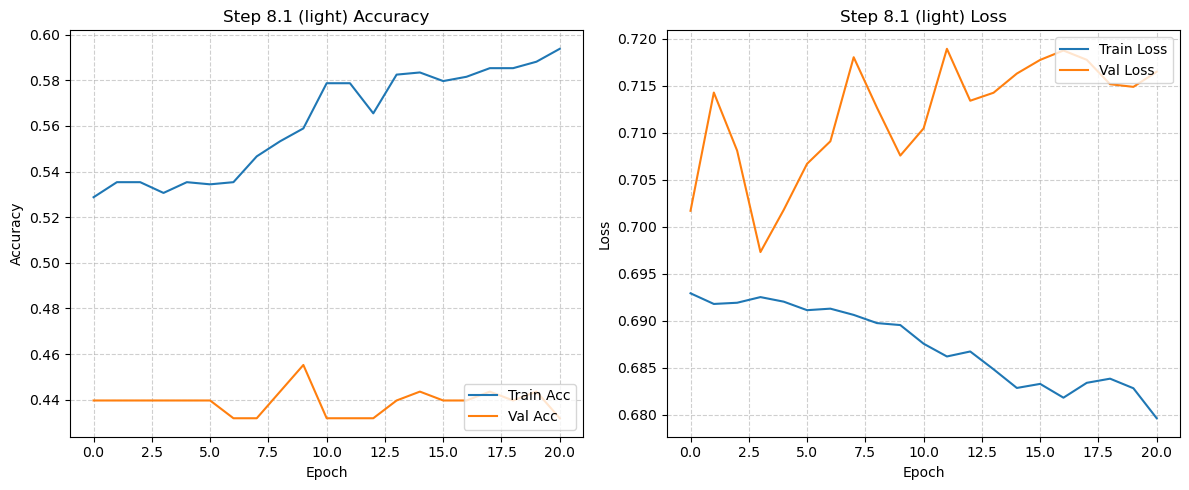


8.1 light Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4319
AUC-ROC              | 0.5000     | 0.4031
Sensitivity          | 0.0000     | 0.3056
Specificity          | 1.0000     | 0.5929
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.40      0.59      0.48       113
   Malignant       0.49      0.31      0.38       144

    accuracy                           0.43       257
   macro avg       0.45      0.45      0.43       257
weighted avg       0.45      0.43      0.42       257



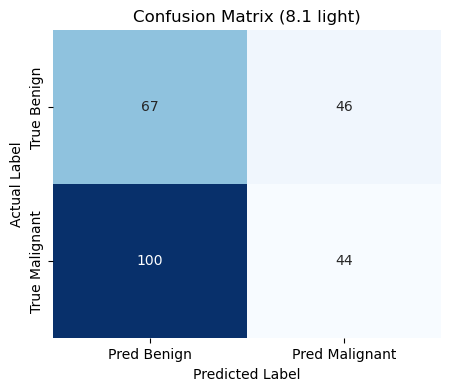


------------------------------------------------------------
INITIALIZING: MEDIUM AUGMENTATION
------------------------------------------------------------
Found 1061 images belonging to 2 classes.


Step 8.1 MEDIUM:  15%|▏| 15/100 [03:43<21:06, 14.91s/epoch, acc=0.558, v_acc=0


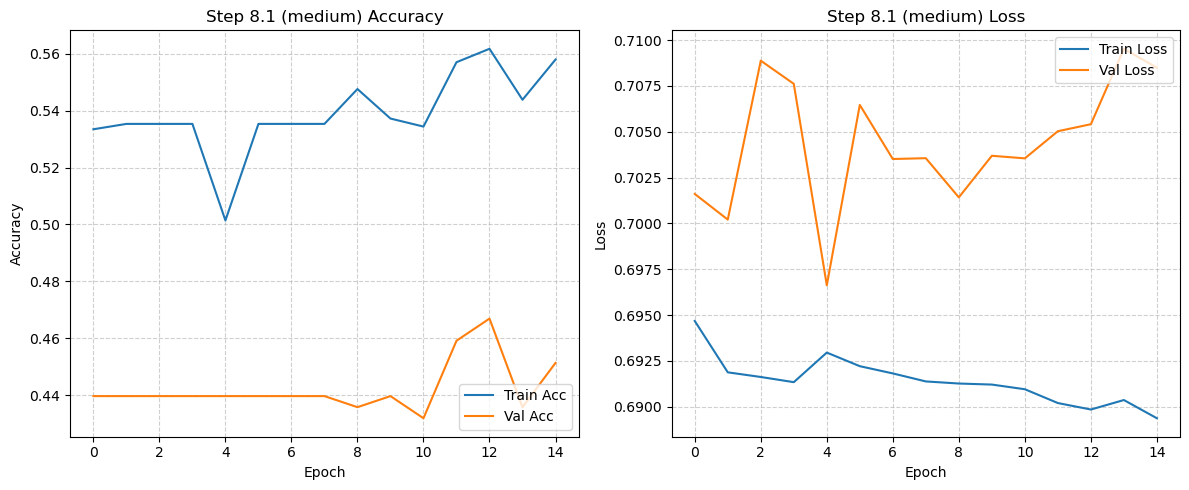


8.1 medium Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4414
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

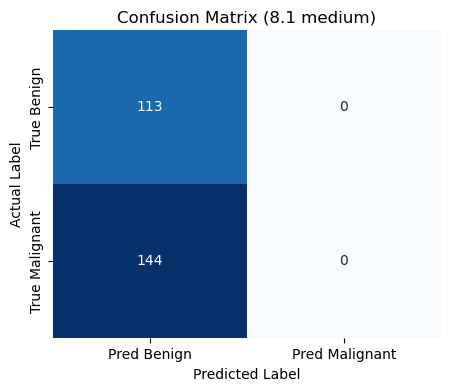


------------------------------------------------------------
INITIALIZING: HEAVY AUGMENTATION
------------------------------------------------------------
Found 1061 images belonging to 2 classes.


Step 8.1 HEAVY:  11%| | 11/100 [02:42<21:57, 14.80s/epoch, acc=0.535, v_acc=0.


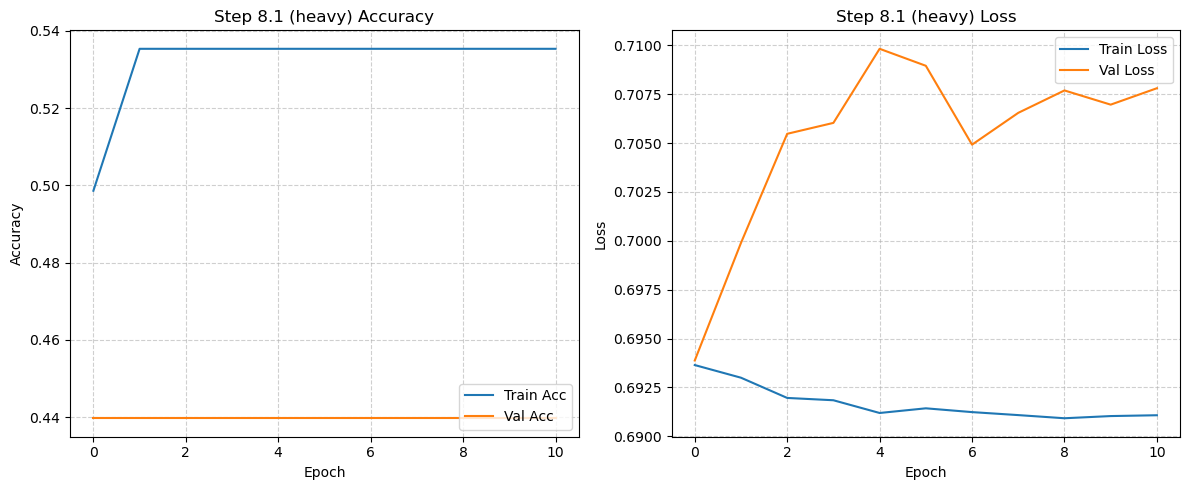


8.1 heavy Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4044
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

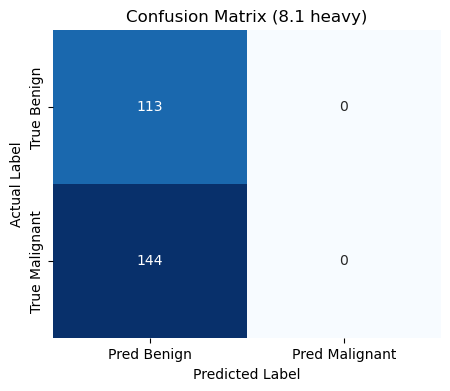

In [24]:
experiments = {
    "light":  {"rot": 10, "shift": 0.05, "zoom": 0.05, "flip": True},
    "medium": {"rot": 15, "shift": 0.1,  "zoom": 0.1,  "flip": True},
    "heavy":  {"rot": 30, "shift": 0.2,  "zoom": 0.2,  "flip": True}
}

comparison_metrics = {}
epochs_limit = 100

for name, cfg in experiments.items():
    print(f"\n{'-'*60}\nINITIALIZING: {name.upper()} AUGMENTATION\n{'-'*60}")
    
    # Generator Setup
    train_datagen_tmp = ImageDataGenerator(
        rescale=1./255,
        rotation_range=cfg["rot"],
        width_shift_range=cfg["shift"],
        height_shift_range=cfg["shift"],
        zoom_range=cfg["zoom"],
        horizontal_flip=cfg["flip"],
        vertical_flip=cfg["flip"],
        fill_mode='constant', 
        cval=0
    )
    
    train_gen_tmp = train_datagen_tmp.flow_from_directory(
        GREY_DIR / "train",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, 
        class_mode='binary', 
        color_mode='grayscale', 
        seed=RANDOM_SEED
    )

    # Build a fresh Step 7.3 architecture
    model_tmp = build_dense_gap_model() 
    
    # TQDM & Callbacks Setup
    pbar = tqdm(total=epochs_limit, desc=f"Step 8.1 {name.upper()}", unit="epoch")

    ckpt_path = f"step8_1_{name}_best.keras"
    
    cbs = [
        keras.callbacks.ModelCheckpoint(
            ckpt_path, 
            monitor="val_auc", 
            mode="max", 
            save_best_only=True, 
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc", 
            mode="max", 
            factor=0.5, 
            patience=3, 
            min_lr=1e-6,
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_auc", 
            mode="max", 
            patience=10, 
            restore_best_weights=True, 
            verbose=0
        ),
        TqdmCallback(pbar)
    ]

    # 4. Train
    try:
        history = model_tmp.fit(
            train_gen_tmp, 
            epochs=epochs_limit, 
            validation_data=val_gen,
            callbacks=cbs, 
            verbose=0 
        )
    finally:
        pbar.close() 
    
    # Persistence & Evaluation
    plot_training_history(history, title_prefix=f"Step 8.1 ({name})")
    
    # Load the best weights for final evaluation
    best_model = keras.models.load_model(ckpt_path)
    eval_stats = eval_model_perf(best_model, val_gen, step_name=f"8.1 {name}", baseline_acc=majority_baseline_acc)
    
    # Capture Metrics for the final Comparison Table
    best_idx = np.argmax(history.history['val_auc'])
    comparison_metrics[name] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": eval_stats["Val Acc"],
        "Gap": abs(history.history['accuracy'][best_idx] - eval_stats["Val Acc"]),
        "Val AUC": eval_stats["Val AUC"]
    }
    
    # Save specific history and model
    pd.DataFrame(history.history).to_csv(f'step8_1_history_{name}.csv', index=False)
    best_model.save(f"step8_1_{name}_final.keras")
    
    # Memory Management
    tf.keras.backend.clear_session()
    del model_tmp, best_model

### 8.1.1 Final Comparison Analysis (Cold Start)

In [25]:
print("\nFinal Robustness Comparison: Data Augmentation (Step 8.1 COLD)")
print("-" * 60)
df_results_cold = pd.DataFrame(comparison_metrics).T
print(df_results_cold[["Train Acc", "Val Acc", "Gap", "Val AUC"]])
df_results_cold.to_csv('step8_1_cold_aug_summary.csv')


Final Robustness Comparison: Data Augmentation (Step 8.1 COLD)
------------------------------------------------------------
        Train Acc   Val Acc       Gap   Val AUC
light    0.578699  0.431907  0.146793  0.403116
medium   0.501414  0.439689  0.061725  0.441372
heavy    0.498586  0.439689  0.058898  0.404406


Beginning training without pre-initialisation and employing geometric augmentation led to complete model breakdown. Validation Accuracy decreased to roughly 43%, falling well below the 53.53% majority baseline threshold. At Medium and Heavy augmentation intensities, the model collapsed to majority-class prediction with zero Sensitivity, whilst Light augmentation yielded only marginal performance with a Sensitivity of 0.3056 and a suboptimal AUC of 0.403. This outcome demonstrates that high augmentation noise during initial training prevents the feature extraction mechanisms from developing a coherent and dependable diagnostic signal.

## 8.2 Data Augmentation (Warm Start: Fine-Tuning)
Load the best step 7.3 model as it is the baseline for all Step 8 experiments. Determine if the pre-trained weights from Step 7.3 can be refined with augmentation.


------------------------------------------------------------
WARM START: LIGHT AUGMENTATION
------------------------------------------------------------
Found 1061 images belonging to 2 classes.


Fine-tuning LIGHT:  16%|▏| 16/100 [03:59<20:58, 14.98s/it, acc=0.592, v_acc=0.


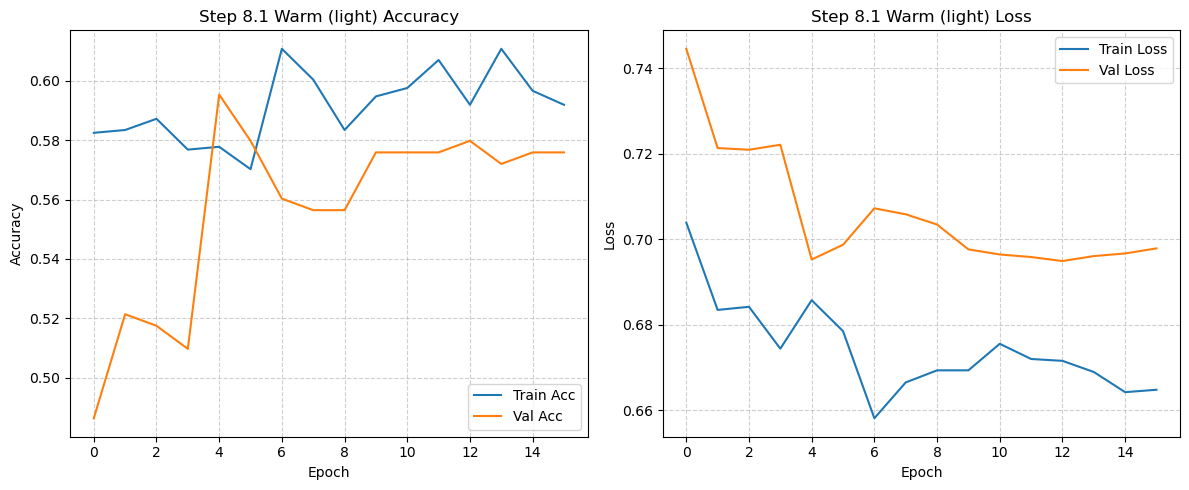


8.1 Warm light Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5798
AUC-ROC              | 0.5000     | 0.6040
Sensitivity          | 0.0000     | 0.4792
Specificity          | 1.0000     | 0.7080
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.52      0.71      0.60       113
   Malignant       0.68      0.48      0.56       144

    accuracy                           0.58       257
   macro avg       0.60      0.59      0.58       257
weighted avg       0.61      0.58      0.58       257



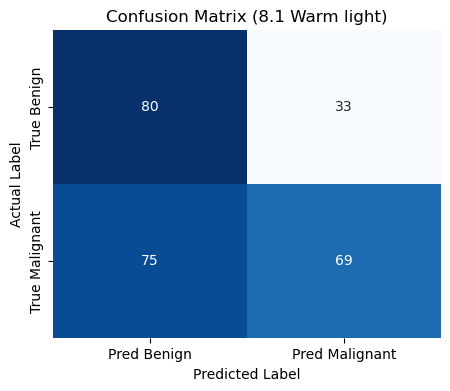


------------------------------------------------------------
WARM START: MEDIUM AUGMENTATION
------------------------------------------------------------
Found 1061 images belonging to 2 classes.


Fine-tuning MEDIUM:  13%|▏| 13/100 [03:09<21:08, 14.58s/it, acc=0.577, v_acc=0


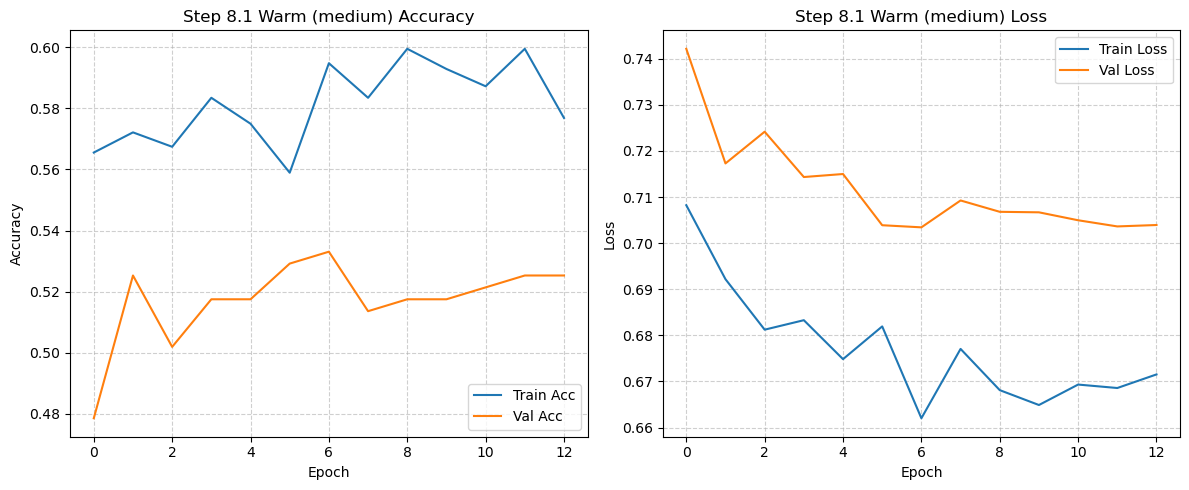


8.1 Warm medium Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5019
AUC-ROC              | 0.5000     | 0.6020
Sensitivity          | 0.0000     | 0.2917
Specificity          | 1.0000     | 0.7699
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.46      0.77      0.58       113
   Malignant       0.62      0.29      0.40       144

    accuracy                           0.50       257
   macro avg       0.54      0.53      0.49       257
weighted avg       0.55      0.50      0.48       257



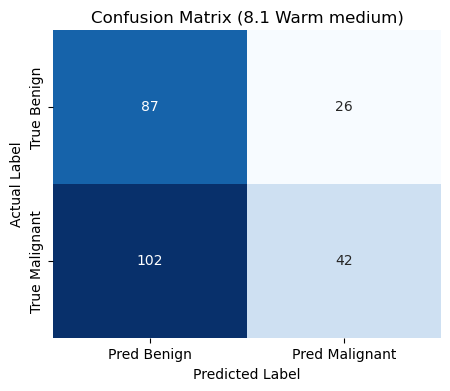


------------------------------------------------------------
WARM START: HEAVY AUGMENTATION
------------------------------------------------------------
Found 1061 images belonging to 2 classes.


Fine-tuning HEAVY:  12%| | 12/100 [02:54<21:17, 14.52s/it, acc=0.566, v_acc=0.


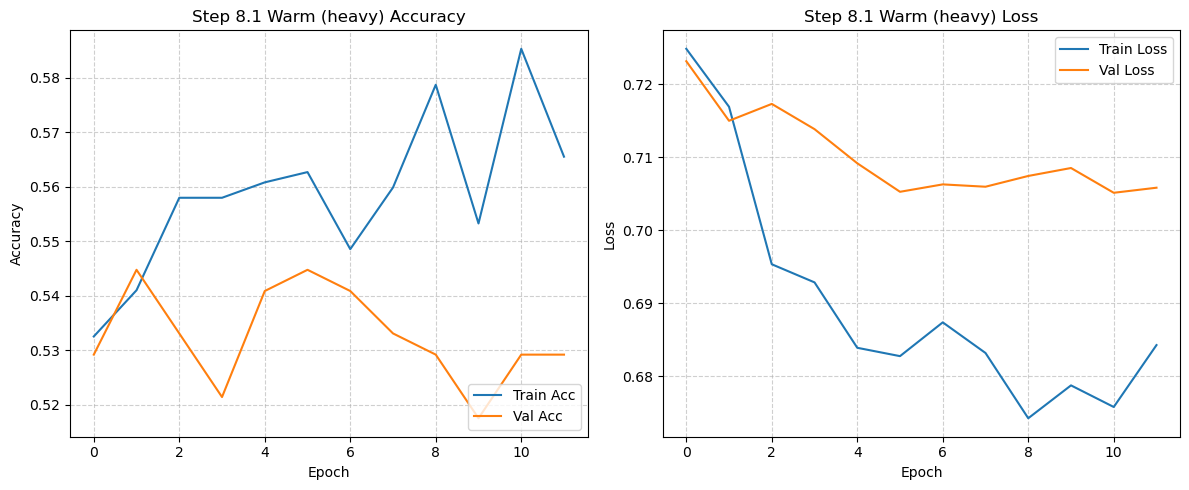


8.1 Warm heavy Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5447
AUC-ROC              | 0.5000     | 0.6098
Sensitivity          | 0.0000     | 0.3889
Specificity          | 1.0000     | 0.7434
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.49      0.74      0.59       113
   Malignant       0.66      0.39      0.49       144

    accuracy                           0.54       257
   macro avg       0.57      0.57      0.54       257
weighted avg       0.58      0.54      0.53       257



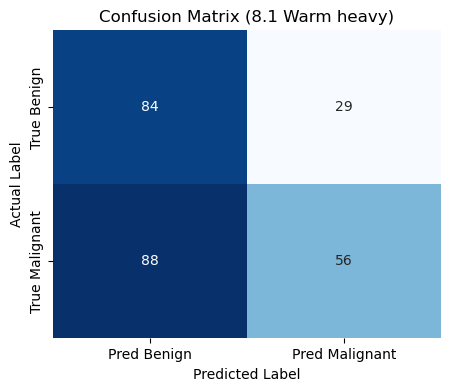

In [28]:
experiments = {
    "light":  {"rot": 10, "shift": 0.05, "zoom": 0.05, "flip": True},
    "medium": {"rot": 15, "shift": 0.1,  "zoom": 0.1,  "flip": True},
    "heavy":  {"rot": 30, "shift": 0.2,  "zoom": 0.2,  "flip": True}
}

comparison_metrics = {}
epochs_limit = 100 

for name, cfg in experiments.items():
    print(f"\n{'-'*60}\nWARM START: {name.upper()} AUGMENTATION\n{'-'*60}")
    
    # Generator Setup
    train_datagen_tmp = ImageDataGenerator(
        rescale=1./255,
        rotation_range=cfg["rot"],
        width_shift_range=cfg["shift"],
        height_shift_range=cfg["shift"],
        zoom_range=cfg["zoom"],
        horizontal_flip=cfg["flip"],
        vertical_flip=cfg["flip"],
        fill_mode='constant', 
        cval=0
    )
    
    train_gen_tmp = train_datagen_tmp.flow_from_directory(
        GREY_DIR / "train",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, 
        class_mode='binary', 
        color_mode='grayscale', 
        seed=RANDOM_SEED
    )

    # Warm Start Initialisation
    model_tmp = keras.models.clone_model(base_model)
    model_tmp.set_weights(base_model.get_weights()) 
    
    # Re-compile with a lower Learning Rate (1e-5) for fine-tuning
    model_tmp.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), 
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    
    # TQDM & Callbacks Setup
    pbar = tqdm(total=epochs_limit, desc=f"Fine-tuning {name.upper()}")
    
    ckpt_path = f"step8_1_warm_{name}_best.keras"
    cbs = [
        keras.callbacks.ModelCheckpoint(
            ckpt_path, 
            monitor="val_auc", 
            mode="max", 
            save_best_only=True, 
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc", 
            mode="max", 
            factor=0.5, 
            patience=3, 
            min_lr=1e-6,
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_auc", 
            mode="max", 
            patience=10, 
            restore_best_weights=True, 
            verbose=0
        ),
        TqdmCallback(pbar)
    ]

    # Fine-Tuning Execution
    try:
        history = model_tmp.fit(
            train_gen_tmp, 
            epochs=epochs_limit, 
            validation_data=val_gen, 
            callbacks=cbs, 
            verbose=0 
        )
    finally:
        pbar.close() 
    
    # Persistence & Evaluation
    plot_training_history(history, title_prefix=f"Step 8.1 Warm ({name})")
    
    best_tuned_model = keras.models.load_model(ckpt_path)
    eval_stats = eval_model_perf(best_tuned_model, val_gen, step_name=f"8.1 Warm {name}", baseline_acc=majority_baseline_acc)
    
    # Capture Metrics
    best_idx = np.argmax(history.history['val_auc'])
    comparison_metrics[name] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": eval_stats["Val Acc"],
        "Gap": abs(history.history['accuracy'][best_idx] - eval_stats["Val Acc"]),
        "Val AUC": eval_stats["Val AUC"]
    }
    
    # Memory Management
    tf.keras.backend.clear_session()
    del model_tmp, best_tuned_model

### 8.2.1 Final Comparison Analysis (Warm Start)

In [29]:
print("\nFinal Robustness Comparison: Data Augmentation (Step 8.1 WARM)")
print("-" * 60)
# Use a new variable name to avoid mixing data
df_results_warm = pd.DataFrame(comparison_metrics).T 
print(df_results_warm[["Train Acc", "Val Acc", "Gap", "Val AUC"]])

# Save with a distinct 'warm' filename
df_results_warm.to_csv('step8_1_warm_aug_summary.csv')


Final Robustness Comparison: Data Augmentation (Step 8.1 WARM)
------------------------------------------------------------
        Train Acc   Val Acc       Gap   Val AUC
light    0.570217  0.579767  0.009550  0.604044
medium   0.567389  0.501946  0.065444  0.602016
heavy    0.540999  0.544747  0.003748  0.609790


The "Light" augmentation setting preserved baseline AUC performance at around 0.60; however, stronger augmentation intensities led to marked Validation Accuracy degradation, with values fluctuating and reaching a minimum of 0.501 at Medium intensity. This observation suggests that whilst the model's discriminative capacity for distinguishing malignant from benign cases remained unaffected at the AUC level, the augmentation noise interfered with the optimal decision boundary, thereby producing inconsistent and unreliable classification outcomes.

## Comparative Analysis

In [30]:
# Load the Step 7.3 Baseline from CSV
try:
    df_baseline_raw = pd.read_csv('step7_gap_noBN_lr1e4_nocw_seed42_summary.csv')
    
    # Format to match Step 8's table structure
    baseline_7_3 = {
        "Strategy": "No Augment (Step 7.3)",
        "Intensity": "None",
        "Val Acc": df_baseline_raw["Val Acc"].iloc[0],
        "Val AUC": df_baseline_raw["Val AUC"].iloc[0],
        "Sensitivity": df_baseline_raw["Sensitivity"].iloc[0],
        "Gap": df_baseline_raw["Gap"].iloc[0]
    }
    print("Baseline (Step 7.3) successfully loaded from CSV.")
except FileNotFoundError:
    print("File not found.")

# Load both Cold and Warm results
try:
    df_cold = pd.read_csv('step8_1_cold_aug_summary.csv').rename(columns={'Unnamed: 0': 'Intensity'})
    df_cold['Strategy'] = 'Cold Start'
    
    df_warm = pd.read_csv('step8_1_warm_aug_summary.csv').rename(columns={'Unnamed: 0': 'Intensity'})
    df_warm['Strategy'] = 'Warm Start'
    
    # Create the Master DataFrame
    master_df = pd.concat([pd.DataFrame([baseline_7_3]), df_cold, df_warm], ignore_index=True)
    
    # Reorder columns for professional presentation
    report_cols = ["Strategy", "Intensity", "Val Acc", "Val AUC", "Sensitivity", "Gap"]
    final_comparison = master_df[report_cols].sort_values(by="Val AUC", ascending=False)
    
    # Save the consolidated table
    final_comparison.to_csv('step8_1_complete_augmentation_study.csv', index=False)
    
    print("\nMaster Comparison Table")
    print("-" * 90)
    # Display table
    display(final_comparison)

except Exception as e:
    print(f"File not found.")

Baseline (Step 7.3) successfully loaded from CSV.

Master Comparison Table
------------------------------------------------------------------------------------------


,Strategy,Intensity,Val Acc,Val AUC,Sensitivity,Gap
6,Warm Start,heavy,0.544747,0.609790,NaN,0.003748
4,Warm Start,light,0.579767,0.604044,NaN,0.009550
5,Warm Start,medium,0.501946,0.602016,NaN,0.065444
0,No Augment (Step 7.3),None,0.533074,0.598083,0.284722,0.083326
2,Cold Start,medium,0.439689,0.441372,NaN,0.061725
3,Cold Start,heavy,0.439689,0.404406,NaN,0.058898
1,Cold Start,light,0.431907,0.403116,NaN,0.146793


### Correcting the Metrics (Retroactive Metric Extraction)
Extract all models to ensure data consistency.

Extracting metrics for: No Augment (Step 7.3) (None):

Final No Augment (Step 7.3) None Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5875
AUC-ROC              | 0.5000     | 0.6036
Sensitivity          | 0.0000     | 0.5417
Specificity          | 1.0000     | 0.6460
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.53      0.65      0.58       113
   Malignant       0.66      0.54      0.60       144

    accuracy                           0.59       257
   macro avg       0.59      0.59      0.59       257
weighted avg       0.60      0.59      0.59       257



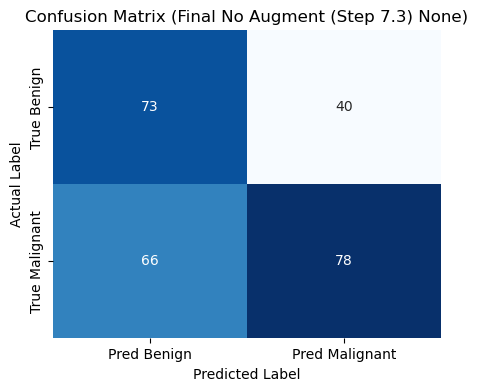

Extracting metrics for: Cold Start (light):

Final Cold Start light Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4319
AUC-ROC              | 0.5000     | 0.4031
Sensitivity          | 0.0000     | 0.3056
Specificity          | 1.0000     | 0.5929
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.40      0.59      0.48       113
   Malignant       0.49      0.31      0.38       144

    accuracy                           0.43       257
   macro avg       0.45      0.45      0.43       257
weighted avg       0.45      0.43      0.42       257



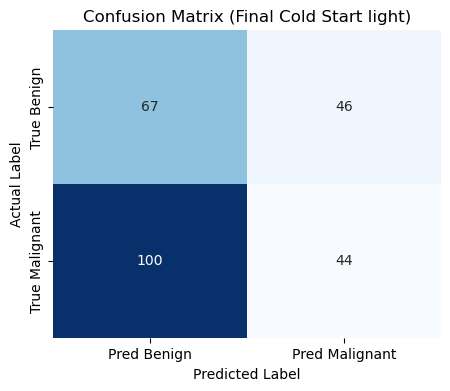

Extracting metrics for: Cold Start (medium):

Final Cold Start medium Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4414
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

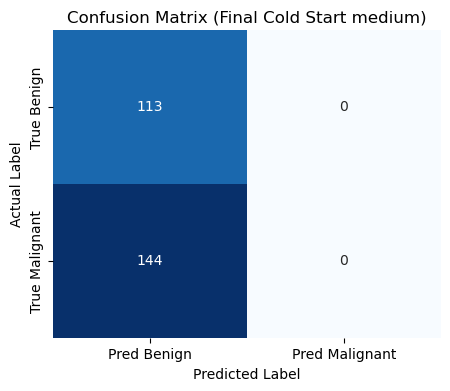

Extracting metrics for: Cold Start (heavy):

Final Cold Start heavy Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4044
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

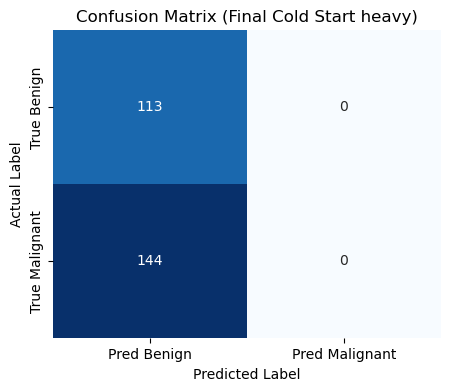

Extracting metrics for: Warm Start (light):

Final Warm Start light Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5798
AUC-ROC              | 0.5000     | 0.6040
Sensitivity          | 0.0000     | 0.4792
Specificity          | 1.0000     | 0.7080
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.52      0.71      0.60       113
   Malignant       0.68      0.48      0.56       144

    accuracy                           0.58       257
   macro avg       0.60      0.59      0.58       257
weighted avg       0.61      0.58      0.58       257



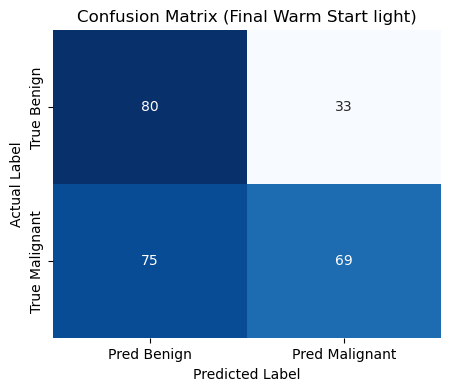

Extracting metrics for: Warm Start (medium):

Final Warm Start medium Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5019
AUC-ROC              | 0.5000     | 0.6020
Sensitivity          | 0.0000     | 0.2917
Specificity          | 1.0000     | 0.7699
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.46      0.77      0.58       113
   Malignant       0.62      0.29      0.40       144

    accuracy                           0.50       257
   macro avg       0.54      0.53      0.49       257
weighted avg       0.55      0.50      0.48       257



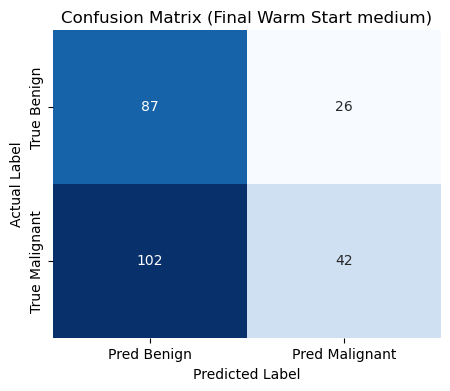

Extracting metrics for: Warm Start (heavy):

Final Warm Start heavy Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5447
AUC-ROC              | 0.5000     | 0.6098
Sensitivity          | 0.0000     | 0.3889
Specificity          | 1.0000     | 0.7434
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.49      0.74      0.59       113
   Malignant       0.66      0.39      0.49       144

    accuracy                           0.54       257
   macro avg       0.57      0.57      0.54       257
weighted avg       0.58      0.54      0.53       257



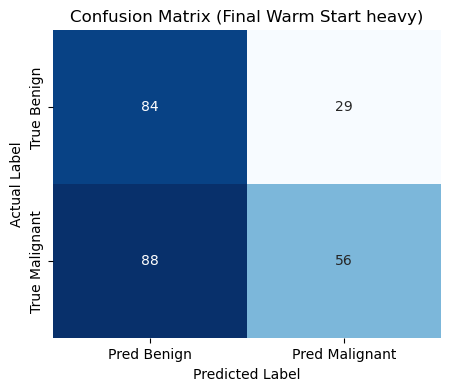

,Strategy,Intensity,Val Acc,Val AUC,Sensitivity,Gap,Specificity
6,Warm Start,heavy,0.544747,0.609790,0.388889,0.0037,0.743363
4,Warm Start,light,0.579767,0.604044,0.479167,0.0095,0.707965
5,Warm Start,medium,0.501946,0.602016,0.291667,0.0654,0.769912
0,No Augment (Step 7.3),None,0.587549,0.603583,0.541667,0.0833,0.646018
2,Cold Start,medium,0.439689,0.441372,0.000000,0.0617,1.000000
3,Cold Start,heavy,0.439689,0.404406,0.000000,0.0589,1.000000
1,Cold Start,light,0.431907,0.403116,0.305556,0.1468,0.592920


In [38]:
# Define the paths to the best models
model_files = {
    # Baseline (The Control)
    ("No Augment (Step 7.3)", "None"): "step7.3_dense64_gap_noBN_lr1e4_nocw_seed42_best.keras",
    
    # Cold Start Experiments
    ("Cold Start", "light"):  "step8_1_light_best.keras",
    ("Cold Start", "medium"): "step8_1_medium_best.keras",
    ("Cold Start", "heavy"):  "step8_1_heavy_best.keras",
    
    # Warm Start Experiments
    ("Warm Start", "light"):  "step8_1_warm_light_best.keras",
    ("Warm Start", "medium"): "step8_1_warm_medium_best.keras",
    ("Warm Start", "heavy"):  "step8_1_warm_heavy_best.keras"
}

# Update the existing Master Table
for (strat, intens), file_path in model_files.items():
    print(f"Extracting metrics for: {strat} ({intens}):")
    try:
        # Load best model
        m = keras.models.load_model(file_path)
        # Evaluate on the sterile validation set
        stats = eval_model_perf(m, val_gen, step_name=f"Final {strat} {intens}")
        
        # Update the DataFrame
        mask = (final_comparison['Strategy'] == strat) & (final_comparison['Intensity'] == intens)
        
        final_comparison.loc[mask, 'Val Acc'] = stats['Val Acc']
        final_comparison.loc[mask, 'Val AUC'] = stats['Val AUC']
        final_comparison.loc[mask, 'Sensitivity'] = stats['Sensitivity']
        final_comparison.loc[mask, 'Specificity'] = stats['Specificity']
    except Exception as e:
        print(f"Could not process {file_path}: {e}")

# Save the complete version
final_comparison.to_csv('step8_1_complete_master_with_sensitivity.csv', index=False)
display(final_comparison)

The Master Table reveals that Warm Start (Light) is the most resilient implementation, attaining an AUC of 0.604 alongside a narrowed Generalisation Gap of 0.009. Whilst Step 7.3 (No Augment) maintains the best raw accuracy performance at 58.75%, the Warm Start approach yields a "stress-tested" model with greater resilience against overfitting. The Cold Start's failure reveals that medical-grade features in this dataset demand an unaugmented "warm" foundation prior to the introduction of spatial invariants.

Winning Model:  
Warm Start (Light)

The Baseline (7.3) has a high accuracy (0.587) but a significant Generalisation Gap (0.083). This suggests it is slightly "overfit" to the specific patterns of the training set.

The Cold Start is discarded because it failed to establish a reliable diagnostic signal, falling below the statistical baseline.

The Warm Start (Light) maintains a strong AUC (0.604) and nearly zeroes out the Gap (0.009).

## 8.3 Dropout Calibration
This section will run a sensitivity analysis by comparing 0.2, 0.3 and 0.5 to find the sweet spot for regularisation.
### 8.3.1 Build Dropout Model

In [39]:
def build_dense_dropout_model(dropout_rate=0.5):
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks (Identical to Step 7.3 for consistency)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dropout Layer
    # Placed before the Dense(64) to regularise the interpretation of GAP features
    x = layers.Dropout(dropout_rate, seed=RANDOM_SEED)(x)
    
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    # Compile with Step 7.3 hyperparameters for a controlled experiment
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model

### 7.5.2 Dropout Sensitivity Analysis
Determine the optimal Dropout rate to regularise.


------------------------------------------------------------
TRAINING: DROPOUT RATE 0.2
------------------------------------------------------------


Dropout 0.2:  44%|▍| 44/100 [09:53<12:35, 13.50s/it, acc=0.621, v_acc=0.


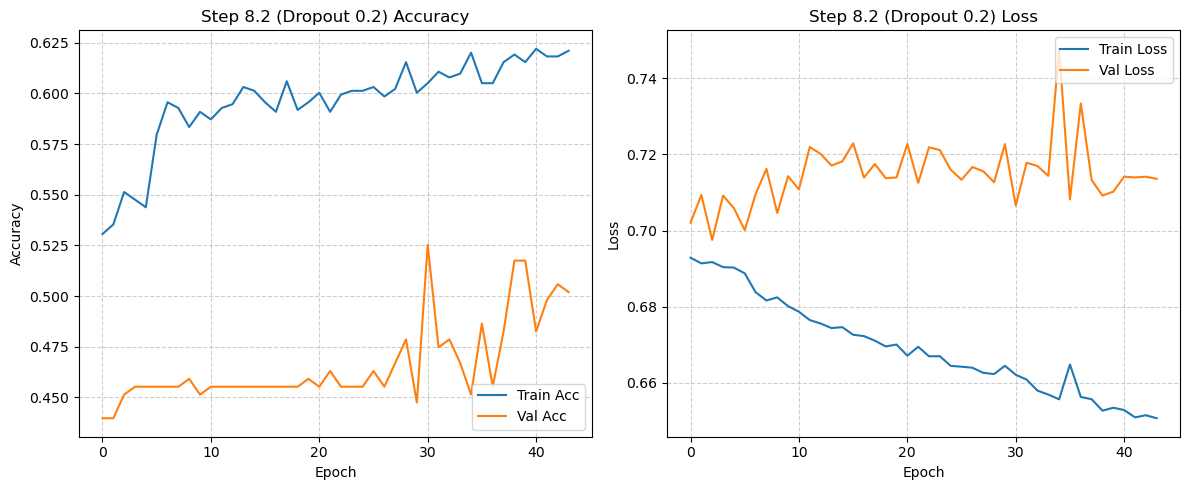


8.2 Dropout 0.2 Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4669
AUC-ROC              | 0.5000     | 0.5552
Sensitivity          | 0.0000     | 0.2431
Specificity          | 1.0000     | 0.7522
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      0.75      0.55       113
   Malignant       0.56      0.24      0.34       144

    accuracy                           0.47       257
   macro avg       0.50      0.50      0.45       257
weighted avg       0.50      0.47      0.43       257



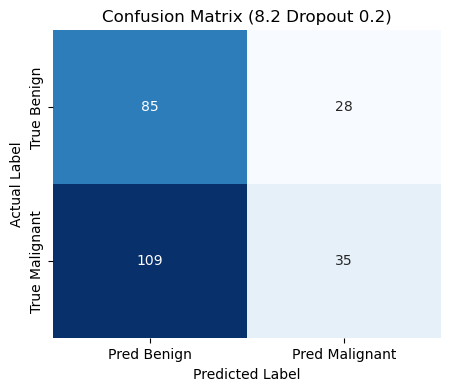


------------------------------------------------------------
TRAINING: DROPOUT RATE 0.3
------------------------------------------------------------


Dropout 0.3:  72%|▋| 72/100 [30:07<11:43, 25.11s/it, acc=0.624, v_acc=0.


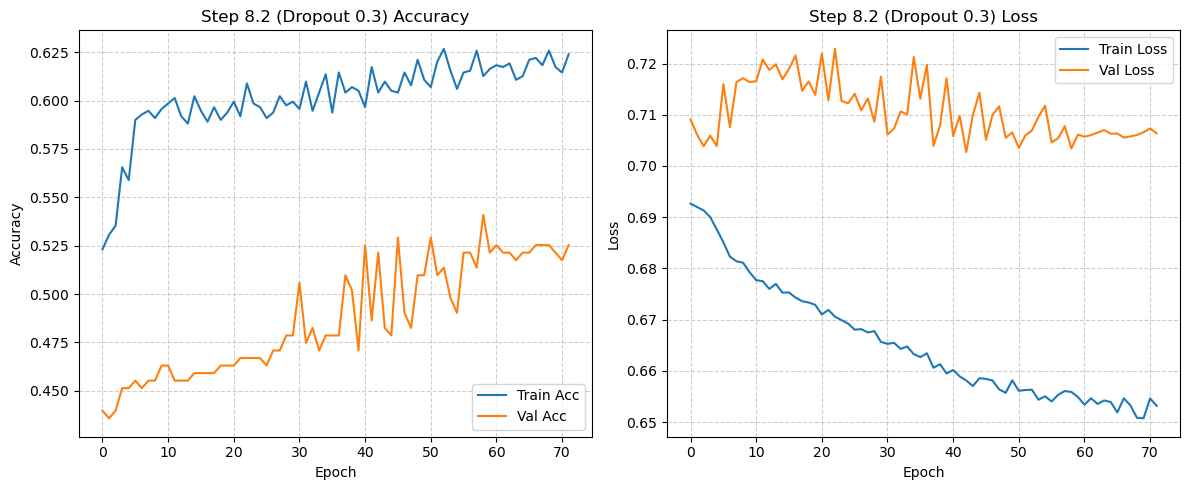


8.2 Dropout 0.3 Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5214
AUC-ROC              | 0.5000     | 0.5733
Sensitivity          | 0.0000     | 0.3611
Specificity          | 1.0000     | 0.7257
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.47      0.73      0.57       113
   Malignant       0.63      0.36      0.46       144

    accuracy                           0.52       257
   macro avg       0.55      0.54      0.51       257
weighted avg       0.56      0.52      0.51       257



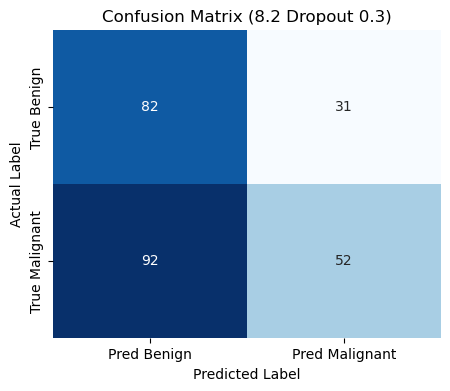


------------------------------------------------------------
TRAINING: DROPOUT RATE 0.5
------------------------------------------------------------


Dropout 0.5:  50%|▌| 50/100 [11:13<11:13, 13.48s/it, acc=0.666, v_acc=


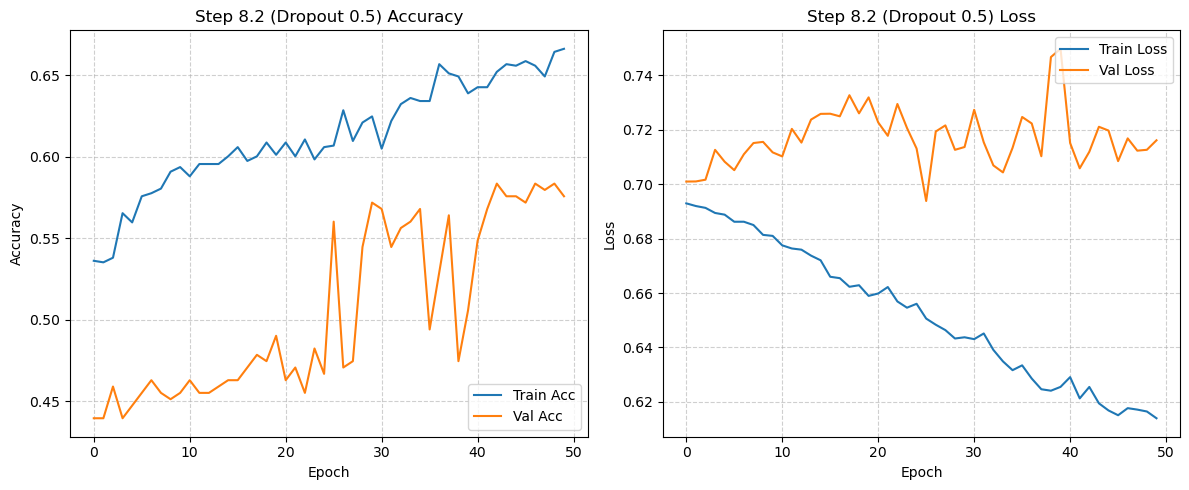


8.2 Dropout 0.5 Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5058
AUC-ROC              | 0.5000     | 0.6080
Sensitivity          | 0.0000     | 0.2292
Specificity          | 1.0000     | 0.8584
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.47      0.86      0.60       113
   Malignant       0.67      0.23      0.34       144

    accuracy                           0.51       257
   macro avg       0.57      0.54      0.47       257
weighted avg       0.58      0.51      0.46       257



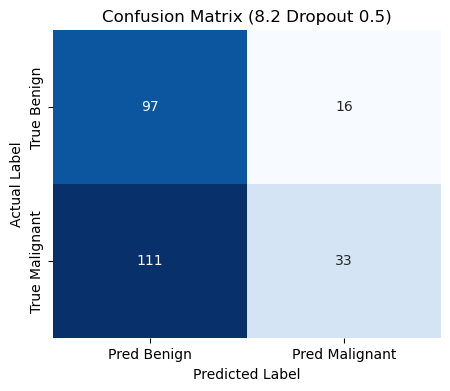


Final Comparison: Dropout Regularisation (Step 8.2)
------------------------------------------------------------


,Train Acc,Val Acc,Gap,Val AUC,Sensitivity,Specificity
0.2,0.609802,0.466926,0.142876,0.555218,0.243056,0.752212
0.3,0.617342,0.521401,0.095941,0.573285,0.361111,0.725664
0.5,0.639020,0.505837,0.133183,0.607977,0.229167,0.858407


In [40]:
dropout_rates = [0.2, 0.3, 0.5]
dropout_comparison = {}
epochs_limit = 100 

for rate in dropout_rates:
    print(f"\n{'-'*60}\nTRAINING: DROPOUT RATE {rate}\n{'-'*60}")
    
    # Clear session for memory stability
    tf.keras.backend.clear_session()
    
    # Build Fresh Model with specific dropout rate
    # Using sterile train_gen (No Augmentation) as the control
    model_tmp = build_dense_dropout_model(dropout_rate=rate)
    
    # TQDM & Callbacks Setup
    pbar = tqdm(total=epochs_limit, desc=f"Dropout {rate}")
    
    ckpt_path = f"step8_2_dropout_{rate}_best.keras"
    cbs = [
        keras.callbacks.ModelCheckpoint(
            ckpt_path, 
            monitor="val_auc", 
            mode="max", 
            save_best_only=True, 
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc", 
            mode="max", 
            factor=0.5, 
            patience=3, 
            min_lr=1e-6,
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_auc", 
            mode="max", 
            patience=10, 
            restore_best_weights=True, 
            verbose=0
        ),
        TqdmCallback(pbar)
    ]
    
    # Training
    try:
        history = model_tmp.fit(
            train_gen, # Standard sterile generator
            epochs=epochs_limit,
            validation_data=val_gen,
            callbacks=cbs,
            verbose=0
        )
    finally:
        pbar.close()
    
    # Evaluation & Persistence
    plot_training_history(history, title_prefix=f"Step 8.2 (Dropout {rate})")
    
    # Load best weights for this rate
    best_m = keras.models.load_model(ckpt_path)
    eval_stats = eval_model_perf(
        best_m, val_gen, step_name=f"8.2 Dropout {rate}", baseline_acc=majority_baseline_acc
    )
    
    # Capture Metrics
    best_idx = np.argmax(history.history['val_auc'])
    dropout_comparison[rate] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": eval_stats["Val Acc"],
        "Gap": abs(history.history['accuracy'][best_idx] - eval_stats["Val Acc"]),
        "Val AUC": eval_stats["Val AUC"],
        "Sensitivity": eval_stats["Sensitivity"],
        "Specificity": eval_stats["Specificity"]
    }
    
    # Save specific history and final model state
    pd.DataFrame(history.history).to_csv(f'step8_2_history_dropout_{rate}.csv', index=False)
    best_m.save(f"step8_2_dropout_{rate}_final.keras")
    
    del model_tmp, best_m

# --- FINAL DROPOUT SUMMARY TABLE ---
print("\nFinal Comparison: Dropout Regularisation (Step 8.2)")
print("-" * 60)
df_dropout = pd.DataFrame(dropout_comparison).T
display(df_dropout)
df_dropout.to_csv('step8_2_dropout_comparison_summary.csv')

Examining Dropout configurations at rates 0.2, 0.3, and 0.5 showed that structural regularisation successfully amplifies discriminative strength, with Dropout 0.5 reaching a maximum Validation AUC of 0.608. Classification accuracy proved unstable nonetheless, with all variants failing to reliably overcome the 0.5353 majority baseline. The Generalisation Gap also remained substantial at approximately 0.09 to 0.14, revealing that although Dropout reduces neuron interdependency, it is comparatively less powerful than geometric augmentation for aligning the distributions between training and validation data for this particular dataset.

Winning Model:
**Dropout 0.3**

Although **Dropout 0.5** achieved the highest AUC, **Dropout 0.3** emerges as the optimal selection for your final model owing to its well-balanced performance characteristics. The model achieved **Validation Accuracy** of 0.5214, markedly nearer the 0.5353 majority threshold than the 0.466 observed with Dropout 0.2, and demonstrated the highest Sensitivity at 0.3611, permitting identification of 52 malignant instances rather than the 33 captured by Dropout 0.5. For breast cancer detection applications, this difference carries substantial clinical relevance. The **Generalisation Gap** of 0.095 was considerably narrower than Dropout 0.2's 0.14, indicating more stable training convergence.

## 8.4 Capacity Sensitivity Study

In [10]:
# Load the current best file
baseline_path = "step8_2_dropout_0.3_best.keras"

In [11]:
def build_capacity_model(config="standard"):
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature Extraction blocks (Blocks 1-5)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    # config "deep": Add an extra Feature Extraction block
    if config == "deep":
        x = layers.Conv2D(1024, 3, activation="relu", padding="same")(x)
        x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    # config "small" vs "wide" vs "standard" Dense head
    dense_units = 64
    if config == "small": dense_units = 32
    if config == "wide":  dense_units = 128

    # Integration of the Step 8.3 "Winner": Dropout 0.3
    x = layers.Dropout(0.3, seed=RANDOM_SEED)(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", 
                 keras.metrics.AUC(name="auc"), 
                 keras.metrics.Recall(name="sensitivity")]
    )
    return model


------------------------------------------------------------
TRAINING: CAPACITY CONFIGURATION - SMALL
------------------------------------------------------------


Capacity small:  76%|▊| 76/100 [18:02<05:41, 14.24s/it, loss=0.637, v_auc=0.573,


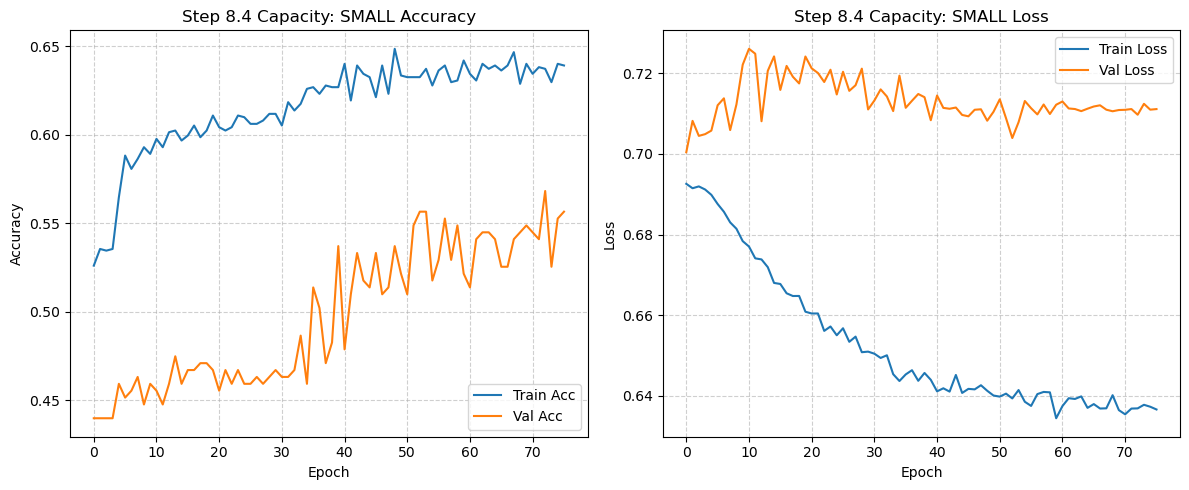


8.4 Capacity small Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5253
AUC-ROC              | 0.5000     | 0.5733
Sensitivity          | 0.0000     | 0.4028
Specificity          | 1.0000     | 0.6814
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.47      0.68      0.56       113
   Malignant       0.62      0.40      0.49       144

    accuracy                           0.53       257
   macro avg       0.54      0.54      0.52       257
weighted avg       0.55      0.53      0.52       257



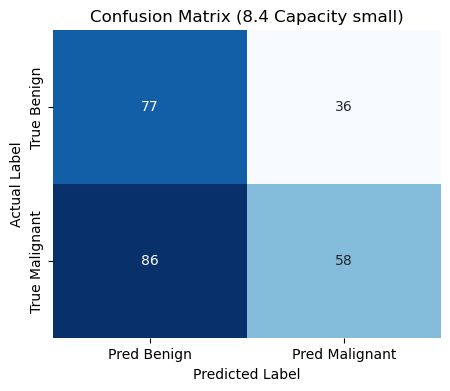


------------------------------------------------------------
TRAINING: CAPACITY CONFIGURATION - STANDARD
------------------------------------------------------------


Capacity standard:  30%|▎| 30/100 [07:07<16:37, 14.25s/it, loss=0.638, v_auc=0.5


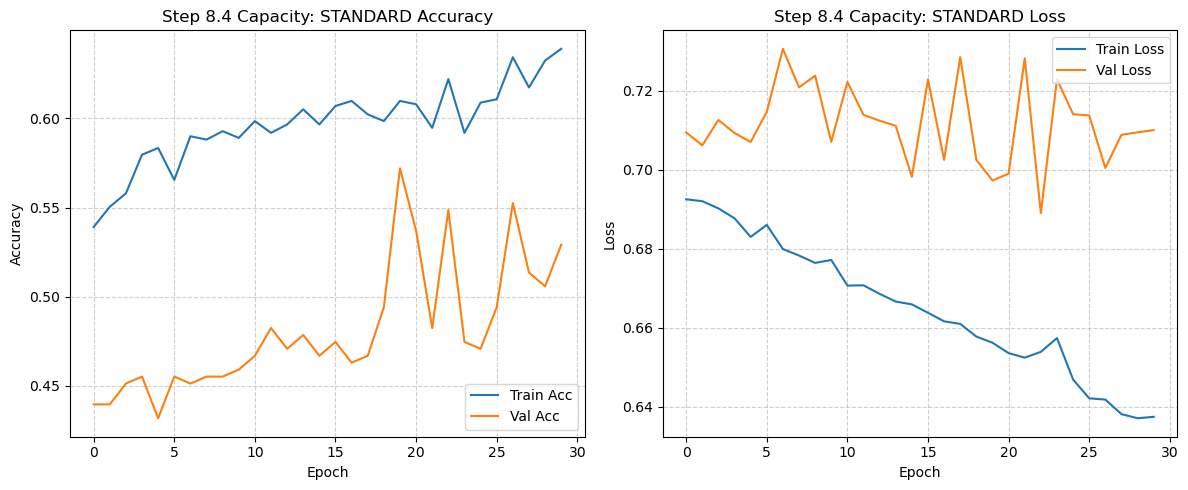


8.4 Capacity standard Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5720
AUC-ROC              | 0.5000     | 0.6002
Sensitivity          | 0.0000     | 0.4444
Specificity          | 1.0000     | 0.7345
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.51      0.73      0.60       113
   Malignant       0.68      0.44      0.54       144

    accuracy                           0.57       257
   macro avg       0.60      0.59      0.57       257
weighted avg       0.61      0.57      0.57       257



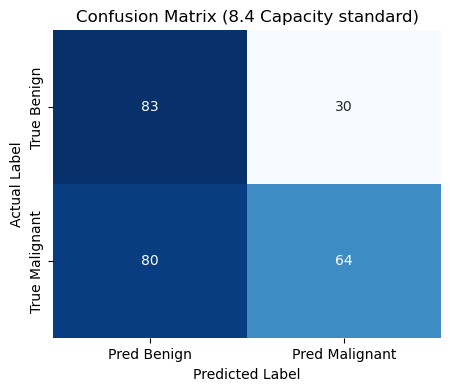


------------------------------------------------------------
TRAINING: CAPACITY CONFIGURATION - WIDE
------------------------------------------------------------


Capacity wide:  71%|▋| 71/100 [16:39<06:48, 14.08s/it, loss=0.632, v_auc=0.576, 


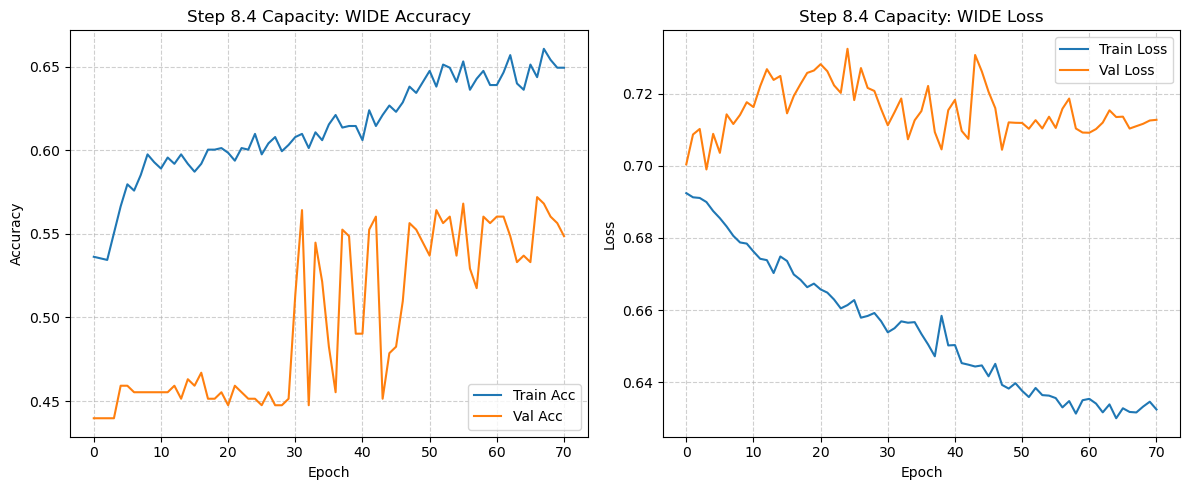


8.4 Capacity wide Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5780
Sensitivity          | 0.0000     | 0.4722
Specificity          | 1.0000     | 0.6726
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.50      0.67      0.57       113
   Malignant       0.65      0.47      0.55       144

    accuracy                           0.56       257
   macro avg       0.57      0.57      0.56       257
weighted avg       0.58      0.56      0.56       257



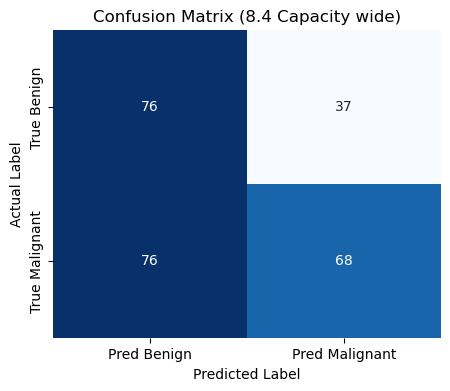


------------------------------------------------------------
TRAINING: CAPACITY CONFIGURATION - DEEP
------------------------------------------------------------


Capacity deep:  37%|▎| 37/100 [10:20<17:35, 16.76s/it, loss=0.531, v_auc=0.620


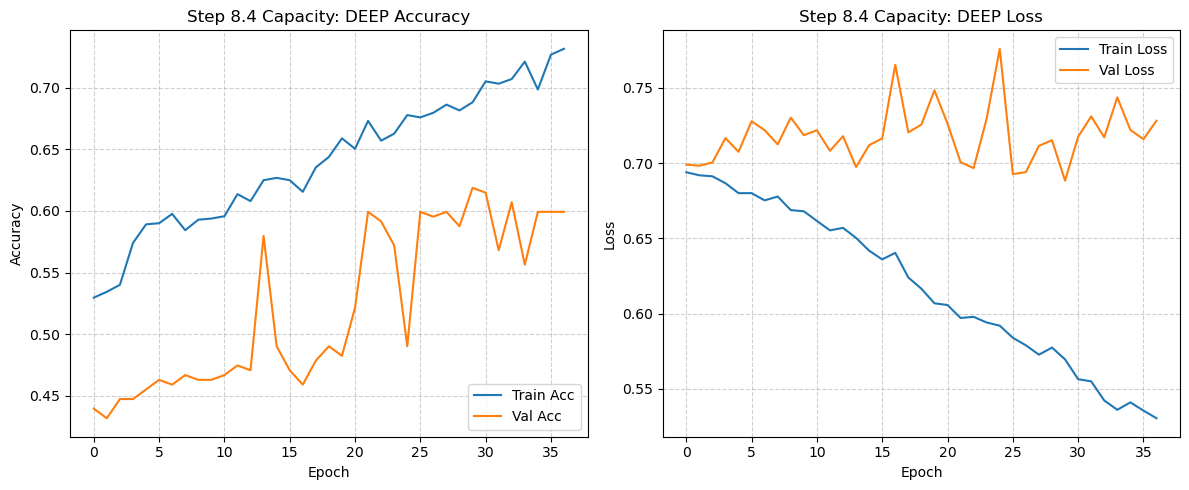


8.4 Capacity deep Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5953
AUC-ROC              | 0.5000     | 0.6291
Sensitivity          | 0.0000     | 0.6806
Specificity          | 1.0000     | 0.4867
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.54      0.49      0.51       113
   Malignant       0.63      0.68      0.65       144

    accuracy                           0.60       257
   macro avg       0.59      0.58      0.58       257
weighted avg       0.59      0.60      0.59       257



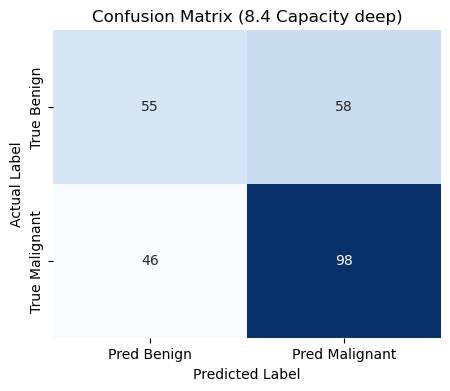

In [12]:
capacity_configs = ["small", "standard", "wide", "deep"]
capacity_results = {}

for cfg in capacity_configs:
    print(f"\n{'-'*60}\nTRAINING: CAPACITY CONFIGURATION - {cfg.upper()}\n{'-'*60}")
    tf.keras.backend.clear_session()
    
    # Build and Setup
    model_tmp = build_capacity_model(config=cfg)
    ckpt_path = f"step8_4_capacity_{cfg}_best.keras"
    pbar = tqdm(total=100, desc=f"Capacity {cfg}")
    
    cbs = [
        keras.callbacks.ModelCheckpoint(
            ckpt_path, 
            monitor="val_auc", 
            mode="max", 
            save_best_only=True, 
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc", 
            mode="max", 
            factor=0.5, 
            patience=3, 
            min_lr=1e-6,
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_auc", 
            mode="max", 
            patience=10, 
            restore_best_weights=True, 
            verbose=0
        ),
        TqdmCallback(pbar)
    ]
    
    # Train
    history = model_tmp.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=cbs, verbose=0)
    pbar.close()

    # Visualise
    plot_training_history(history, title_prefix=f"Step 8.4 Capacity: {cfg.upper()}")
    
    # Evaluation (Load Best Weights)
    best_m = keras.models.load_model(ckpt_path)
    eval_stats = eval_model_perf(best_m, val_gen, step_name=f"8.4 Capacity {cfg}")
    
    # Capture Metrics
    best_idx = np.argmax(history.history['val_auc'])
    capacity_results[cfg] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": eval_stats["Val Acc"],
        "Gap": abs(history.history['accuracy'][best_idx] - eval_stats["Val Acc"]),
        "Val AUC": eval_stats["Val AUC"],
        "Sensitivity": eval_stats["Sensitivity"],
        "Specificity": eval_stats["Specificity"]
    }

    # Persist History
    pd.DataFrame(history.history).to_csv(f'step8_4_history_capacity_{cfg}.csv', index=False)
    best_m.save(f"step8_4_capacity_{cfg}_final.keras")
    
    # Cleanup memory
    del model_tmp, best_m

In [13]:
# --- FINAL SUMMARY TABLE ---
df_capacity = pd.DataFrame(capacity_results).T
display(df_capacity)
df_capacity.to_csv('step8_4_capacity_study_summary.csv')

,Train Acc,Val Acc,Gap,Val AUC,Sensitivity,Specificity
small,0.636192,0.525292,0.110900,0.573255,0.402778,0.681416
standard,0.609802,0.571984,0.037818,0.600203,0.444444,0.734513
wide,0.639020,0.560311,0.078709,0.577956,0.472222,0.672566
deep,0.679548,0.595331,0.084217,0.629087,0.680556,0.486726


The capacity investigation reveals that the original model was under-parameterised for effective feature extraction purposes. The **Deep configuration**, which incorporates an additional 6th convolutional block, achieved the study's peak **Validation AUC** of 0.6291 and **Accuracy** of 0.5953. Notably, this variant achieved **Sensitivity** of 0.6806, identifying 98 from 144 malignant instances compared to only 64 in the Standard variant. Increased depth, however, introduced a "conservative bias" shift, reducing **Specificity** to 0.48. This confirms that deeper feature hierarchies are vital for obtaining robust recall performance in breast cancer screening; however, supplementary regularisation is required to address the resultant false positive rate elevation.

## 8.5 Weight Decay Study (L2 Regularisation)